# HPC Mini-Challenge 2 - Beschleunigung in Data Science
## Teil 2: GPU
#### FHNW - FS2024

Original von S. Suter, angepasst von S. Marcin und M. Stutz

Abgabe von: <font color='blue'>Name hier eintragen</font>

#### Ressourcen
* [Überblick GPU Programmierung](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Vorlesungen und Beispiele aus dem Informatikkurs PAC (parallel computing), siehe Ordner "resources"
* CSCS "High-Performance Computing with Python" Kurs, Tag 3: 
    - JIT Numba GPU 1 + 2
    - https://youtu.be/E4REVbCVxNQ
    - https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
    - Siehe auch aktuelles Tutorial von 2021
* [Google CoLab](https://colab.research.google.com/) oder ggf. eigene GPU.


In [1]:
#!pip install numba

DIS ISSUE: https://github.com/numba/numba/issues/7104

NUMBA_CUDA_DRIVER="/usr/lib/wsl/lib/libcuda.so.1" python -c "from numba import cuda; cuda.detect()" -> this works

In [2]:
!numba -s

Der Befehl "numba" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


In [3]:
%load_ext autoreload
%autoreload 2

In [1]:
# Dummy Beispiel zum testen mit Numba

import math
from numba import vectorize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)
  
a = np.arange(4096,dtype=np.float32)
gpu_sqrt(a)

c:\Users\Stephan\AppData\Local\pypoetry\Cache\virtualenvs\hpc-mc2-buesst1-d94spYeM-py3.11\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 6 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 0.       ,  1.       ,  1.4142135, ..., 63.97656  , 63.98437  ,
       63.992188 ], dtype=float32)

### 5 GPU Rekonstruktion

Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting. Code aus dem ersten Teil darf dabei verwendet werden. Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind. Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein. Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden. Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst. Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest.

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)

### GPU-basierte SVD-Rekonstruktion

Die Aufgabe besteht darin, eine Singularwertzerlegung (SVD) effizient auf der GPU zu implementieren, um eine Matrix zu rekonstruieren. Hierbei wurde die Berechnung der einzelnen Elemente der Zielmatrix auf der GPU mittels eines CUDA-Kernels ausgelagert, während Steuerlogik und Speicheroperationen auf der CPU verbleiben. Meine Implementierung basiert vollständig auf Numba.

#### Rekonstruktionsstrategie

Die Rekonstruktion einer Matrix $Y$ aus den SVD-Komponenten $U$, $S$ und $V^T$ basiert auf der Formel:

$$
Y_{m,n} = \sum_{p=1}^{k} U_{m,p} \cdot S_p \cdot V^T_{p,n}
$$

Da $S$ eine Diagonalmatrix ist, kann jeder Eintrag $Y_{m,n}$ unabhängig berechnet werden, indem über die ersten $k$ Singulärwerte iteriert wird. Diese Unabhängigkeit erlaubt eine effiziente Parallelisierung auf der GPU, bei der jedes Element $Y_{m,n}$ gleichzeitig von einem eigenen Thread berechnet wird.

In den ersten Experimenten nutze ich nur das global memory. Die nachfolgenden Annahmen treffen aber auch auf den Kernel mit shared memory zu.

#### Designentscheidungen & Annahmen

Eine NVIDIA-GPU besteht aus mehreren **Streaming Multiprocessors (SMs)**, die die parallele Berechnung ermöglichen. Die von mir verwendete NVIDIA RTX 4090 verfügt über 128 SMs. Jeder SM enthält:
- **CUDA-Kerne**, die Rechenoperationen ausführen,
- **Register**, die Threads für schnelle Berechnungen (durch schnelleren Memoryzugriff als global Memory) nutzen können,
- **Shared Memory**, der von Threads eines Blocks gemeinsam genutzt werden kann (schnelleres Memory als global Memory, kann von mehreren Threads gemeinsam genutzt werden),
- **L1- und L2-Caches**, die Speicherzugriffe beschleunigen (habe ich als Programmierer keinen direkten Einfluss),
- sowie **Warp-Scheduler**, die Threads in Gruppen, den sogenannten **Warps**, steuern.

Ein Warp besteht aus **32 Threads**, die nach dem **Single Instruction Multiple Data (SIMD)**-Prinzip arbeiten. Das bedeutet, alle Threads eines Warps führen die gleiche Instruktion aus, jedoch auf unterschiedlichen Daten. Divergieren Threads in ihrem Kontrollfluss (z. B. durch if-else-Konstrukte), müssen diese nacheinander ausgeführt werden, was die Effizienz des Warps verringert. Dies wird als **Warp-Divergenz** bezeichnet und sollte bei der Kernel-Implementierung vermieden werden.

Deshalb habe ich meinen Kernel so simpel wie möglich designed, wobei die Warp-Divergenz nur bei Threads auftreten kann, welche sich ausserhalb der Zielmatrix befindet (globale Threadid ausserhalb der Zielmatrix).

#### Blöcke, Threads und Speicherzugriff

Ein **Block** ist eine Sammlung von Threads, die auf einem SM ausgeführt werden. Threads innerhalb eines Blocks können über den **Shared Memory** miteinander kommunizieren, was wesentlich schneller ist als Zugriffe auf den **Global Memory**, der für die gesamte GPU zugänglich ist. Der **Global Memory** hat eine hohe Latenz, daher ist es wichtig, dass Daten, die häufig oder von mehreren Threads benötigt werden, in den Shared Memory verschoben werden. In meinem Fall wäre dies die Diagonalmatrix $S$, welche für jedes Element der Zielmatrix benötigt wird. Im 5.2.2 habe ich diese Verbesserung implementiert.

Die Effizienz des **Global Memory-Zugriffs** hängt von der Anordnung der Daten ab:
- **Memory Coalescing:** Wenn Threads eines Warps auf aufeinanderfolgende Speicheradressen zugreifen, können diese Daten in einem einzigen Ladevorgang übertragen werden.
- **Strided oder random access:** Zugriffe mit unregelmässigen Adressmustern führen zu mehrfachen Speicherzugriffen und reduzieren die Effizienz erheblich.

Die Grösse eines Blocks beeinflusst, wie viele Blöcke gleichzeitig auf einem SM ausgeführt werden können. Zu grosse Blöcke können die Anzahl gleichzeitig laufender Blöcke reduzieren, was sich negativ auf die Occupancy auswirken. Ausserdem ist eine SM auch durch ihre Ressourcen (Cache, Register etc) begrenzt. Ist die Blockgrösse zu klein, kann das dazu führen dass ein solcher zu wenig Threads hat um eine SM optimal auszulasten. Auch das führt zu einer nicht optimalen Warp-Occupancy. Ausserdem sollte die Blockgrösse so gewählt werden, dass diese ein vielfaches von 32 ist, damit alle Threads in Warps ausgeführt werden können.

Ein paar erste Versuche haben ausserdem gezeigt, dass die Berechnung der Rekonstruktion am schnellsten ist, wenn alle Inputs in den Kernel row-major sind. Die Ergebnisse habe ich allerdings nirgends aufgezeigt, da mein Code ansonnsten sehr überladen würde. Deshalb sind alle Kernelparameter in meinen Experimenten row-major.

#### Bank Conflicts im Shared Memory

Der **Shared Memory** eines SMs ist in 32 **Speicherbänke** unterteilt, die parallelen Zugriff ermöglichen. Jeder Speicherbank ist ein bestimmter Adressbereich zugeordnet. Ein **Bank Conflict** tritt auf, wenn mehrere Threads eines Warps gleichzeitig auf Adressen zugreifen, die zur gleichen Speicherbank gehören. In diesem Fall müssen die Zugriffe seriell ausgeführt werden, was die Parallelität innerhalb des Warps reduziert.

Bank Conflicts können durch geschickte Datenanordnung und Padding vermieden werden. Dies stellt sicher, dass Threads auf unterschiedliche Speicherbänke zugreifen können, um die maximale Parallelität des Shared Memory zu nutzen.

Um bank-conflicts zu vermeiden habe ich im shared memory Kernel die tile-size auf 32 respektive 16 begrenzt.

In [5]:
from src.utils import get_n_timings_from_inputs_and_kernels, make_reconstructor, random_svd, reconstruct_svd_broadcast_timeit
from src.kernels.global_mem import fp32 as kernel_globalmem_fp32
from src.kernels.global_mem import fp64 as kernel_globalmem_fp64

Der Code wurde modularisiert, um die Übersichtlichkeit und Wiederverwendbarkeit zu gewährleisten. Zwei Varianten des CUDA-Kernels wurden implementiert: eine 64-Bit-Version (fp64) für höhere Genauigkeit und eine 32-Bit-Version (fp32) für schnellere Ausführung. Beide Varianten arbeiten ausschliesslich mit globalem Speicher. In einer späteren Version wird der Kernel zusätzlich mit Shared Memory optimiert, mit dem Ziel die Effizienz weiter zu steigern.

Die Funktion `make_reconstructor` generiert eine rekonfigurierbare Funktion zur SVD-Rekonstruktion basierend auf dem übergebenen CUDA-Kernel. Sie bietet folgende Parameter:

- **kernel (callable):** Der CUDA-Kernel zur Rekonstruktion.
- **block_size (tuple):** Die Grösse der CUDA-Thread-Blöcke (Threads pro Block).
- **pin_memory (bool):** Option, ob für das Ausgabe-Array gepinnter Speicher verwendet werden soll (beschleunigt den Datenfluss zwischen GPU und Host). Standardmässig deaktiviert.
- **timeit (bool):** Gibt an, ob Laufzeiten gemessen und zurückgegeben werden sollen. Standardmässig deaktiviert.

Basierend auf der Kernel-Signatur werden automatisch die benötigten Datentypen und die Speicheranordnung (Row- oder Column-Major) der Eingabedaten abgeleitet. Dadurch wird sichergestellt, dass die Daten korrekt auf die GPU übertragen und verarbeitet werden. Optional kann auch das Ausgabe-Array in gepinntem Speicher bereitgestellt werden, um den Datentransfer von der GPU zum Host zu beschleunigen.

Die Funktion unterstützt damit eine flexible SVD-Rekonstruktion und erlaubt Vergleiche zwischen verschiedenen Konfigurationen, wie z.B. Genauigkeit (fp64) und Geschwindigkeit (fp32).

In [6]:
u, s, vt = random_svd((5000, 5000))
k = len(s)

cpu_reconstruction, time_cpu = reconstruct_svd_broadcast_timeit(u, s, vt, k)

Ich erstelle zuerst zufällige Matrizen, welche sich zu einer 5000x5000 Matrix rekonstruieren lassen. Als k verwende ich die Originalgrösse, damit am meisten Berchnungen durchgeführt werden müssen.

In [7]:
reco_func = make_reconstructor(kernel_globalmem_fp64, (4, 8), timeit=True)

Nun erstelle ich eine Rekonstruktionsfunktion, welche den fp64 Kernel nutzt mit einer Blockgrösse von (4x8). Dieser komplette Block sollte theoretisch auf einem einzelnen Warp ausgeführt werden können, weil 4x8 = 32 = num threads per Warp.

In [8]:
gpu_result, time_gpu = reco_func(u,s,vt,k)

np.allclose(cpu_reconstruction, gpu_result)

True

Wie unschwer zu erkennen ist, hat die Rekonstruktion funktioniert. Die GPU liefert das gleiche Resultat wie wie CPU.

In [9]:
print("CPU Time:")
display(time_cpu)

print("GPU Time:")
display(time_gpu)

CPU Time:


{'total': 0.44904065132141113}

GPU Time:


{'h2d': 0.05193011093139648,
 'd_maloc_y': 1.8240000354126097e-06,
 'h_maloc_y': 1.0239999974146486e-06,
 'kernel': 0.4092199096679688,
 'd2h': 0.03465318298339844,
 'mem_operations_total': 0.08658614191482775,
 'total': 0.49580605158279656}

Hier sind nun verschiedene Zeitmessungen zu erkennen.

Bei der CPU gibt es nur die totale Rekonstruktionszeit.

Bei der GPU wurden noch ein paar weitere Metriken, wie:

- *h2d*: Zeit in Sekunden, welche benötigt wird die Daten von der CPU zur GPU zu senden
- *d_maloc_y*: Zeit in Sekunden, welche benötigt wird die output Matrix auf der GPU zu alloziieren
- *h_maloc_y*: Zeit in Sekunden, welche benötigt wird die output Matrix auf der CPU zu alloziieren
- *kernel*: Kernel execution time in Sekunden
- *d2h*: Zeit in Sekunden welche benötigt wird die Daten von der GPU auf die CPU zu senden
- *mem_operations_total*: h2d + d_maloc_y + h_maloc_y + d2h
- *total*: Totale Zeit in Sekunden

Wie man erkennen kann, benötigt die GPU total mehr Zeit als die CPU. Die Kernel execution time ist allerdings etwas kleiner als die totale Zeit der Berechnung der CPU. Das bedeutet also, dass die Berechnung auf der GPU schneller läuft, allerdings benötigt die Übertragung der Daten zur GPU auch einiges an Zeit, was schlussendlich zu einer langsameren totalen Zeit führt.

In [10]:
reco_func = make_reconstructor(kernel_globalmem_fp32, (4, 8), timeit=True)
gpu_result, time_gpu = reco_func(u,s,vt,k)

np.allclose(cpu_reconstruction, gpu_result)

False

Diesmal habe ich den 32-Bit-Kernel verwendet, da dieser theoretisch deutlich schneller sein sollte als die 64-Bit-Version. GPUs sind bei 32-Bit-Operationen erheblich effizienter. Laut NVIDIA liegt der Durchsatz bei der RTX 4090 bei 64-Bit-Operationen um das 64-Fache unter dem von 32-Bit-Operationen.

Was hier auch deutlich wird ist die Präzision. np.allclose gibt nun ein False zurück. Dies deutet darauf hin, dass die Rekonstruktion nicht mehr die Genauigkeit besitzt wie die 64 Bit Rekonstruktion.

In [11]:
cpu_reconstruction[:4, :4]

array([[-61.4144044 ,  11.13896492,  -3.78707305,  -7.31349288],
       [ 17.25892073,  37.44792639, -28.84758812, -16.44853879],
       [ 13.15815405,  -6.8569823 ,  -0.61267374,  18.31413186],
       [ 19.54096879,  61.8412671 ,  65.28658868,  34.69090339]])

In [12]:
gpu_result[:4, :4]

array([[-61.414413 ,  11.138971 ,  -3.7870774,  -7.3134537],
       [ 17.258926 ,  37.44798  , -28.847603 , -16.448545 ],
       [ 13.15816  ,  -6.8569837,  -0.6126534,  18.314177 ],
       [ 19.540934 ,  61.841316 ,  65.28666  ,  34.69083  ]],
      dtype=float32)

Vergleicht man die ersten 16 Elemente der Rekonstruktion, so kann man sehen, dass die Rektionstruktion auf ca 3 Stellen nach dem Komma genau ist.

In [13]:
print("CPU Time:")
display(time_cpu)

print("GPU Time:")
display(time_gpu)

CPU Time:


{'total': 0.44904065132141113}

GPU Time:


{'h2d': 0.02576076889038086,
 'd_maloc_y': 2.0479999948292972e-06,
 'h_maloc_y': 1.0239999974146486e-06,
 'kernel': 0.16917181396484376,
 'd2h': 0.017377056121826173,
 'mem_operations_total': 0.043140897012199274,
 'total': 0.21231271097704305}

Hier zeigt sich, dass sowohl die Kernel-Execution-Time als auch die Transferzeiten von Host zu Device (h2d) und Device zu Host (d2h) bei der 32-Bit-Rekonstruktion kürzer sind als bei der 64-Bit-Version. Dies ist auf zwei Faktoren zurückzuführen: Zum einen sind die Rechenoperationen bei 32 Bit schneller, und zum anderen wird nur die halbe Datenmenge übertragen, was den Datentransfer beschleunigt.

Die Kernel-Execution-Time ist jedoch bei weitem nicht 64-mal kürzer, was darauf hindeutet, dass die Rekonstruktion primär Memory-Bound ist, also durch den Zugriff auf den Speicher limitiert wird.

#### 5.2 GPU-Kernel Performance

##### 5.3.1 Blocks und Input-Grösse

Links: 
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA Kapitel zu "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Grösse der Input-Daten durch. Erstelle dafür ein neues Datenset mit beliebig grossen Matrizen, da die GPU besonders geeignet ist um grosse Inputs zu verarbeiten (Verwende diese untschiedlich grossen Matrizen für alle nachfolgenden Vergeliche und Tasks ebenfalls). Messe die Performance des GPU-Kernels mittels geeigneten Funktionen. Welche Blockgrösse in Abhängigkeit mit der Input-Grösse hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen? Welches sind deiner Meinung nach die Gründe dafür? Wie sind die Performance Unterschiede zwischen deiner CPU und GPU Implementierung? Diskutiere deine Analyse (ggf. mit Grafiken).

In [14]:
matrices = {
    "small_long_33": random_svd((10000, 33)),
    "small_long_32": random_svd((10312, 32)),
    "tiny": random_svd((720, 1280)),
    "small": random_svd((1080, 1920)),
    "medium": random_svd((3072, 4096)),
    "large": random_svd((4320, 7680)),
    "quadratic": random_svd((4096, 4096))
}

# also add k = len(s)
matrices = {key: tuple(list(value) + [len(value[1])]) for key, value in matrices.items()}

Als Basis für die weiteren Experimente nutze ich die folgenden Matrizen:

- *small_long_33*: Eine Matrix mit vielen Zeilen und nur wenig Spalten. Die Spaltenanzahl wurde so gewählt, dass diese eins mehr als 32 besitzt. Diese soll hauptsächlich dazu genutzt werden um aufzuzeigen, was passiert, wenn die Blockgrösse unglücklich gewählt wird.
- *small_long_32*: Eine Matrix mit vielen Zeilen und nur wenig Spalten. Die Spaltenanzahl wurde so gewählt, dass diese genau 32 besitzt. Die Anzahl Zeilen wurde so gewählt dass die Anzahl Elemente ungefär derjenigen von *small_long_33* entspricht.
- *micro*: Matrix welche HD repräsentieren soll (kleinste Matrix).
- *small*: Matrix welche Full HD repräsentieren soll (etwas grössere Matrix).
- *medium*: Matrix welche 4K repräsentieren soll (mittelgrosse Matrix).
- *large*: Matrix welche 8K repräsentieren soll (grösste Matrix).
- *quadratic*: Matrix welche Quadratisch ist.

##### Unglückliche Wahl der Blockgrösse

Im ersten Experiment wird untersucht, welche Effekte auftreten, wenn die Blockgrösse so gewählt wird, dass ein erheblicher Anteil der Threads keine Arbeit verrichtet.

Für die Analyse wurde eine Zielmatrix mit **33 Spalten** und **10000 Zeilen** erstellt. Die gewählte Blockgrösse von *(1, 32)*, was einer Zeile und 32 Spalten entspricht (Anzahl Threads = 32 = 1 Warp), führt dazu, dass Threads auf Basis der Dimensionsgrösse ineffizient arbeiten. Die Threads der Warps welche den Rand der Matrix berechnen müssen, werden blockiert und stehen somit nicht mehr für andere Berechnungen zur verfügung, wodurch die GPU ineffizienter wird.
Dieses Szenario simuliert bewusst eine suboptimale Nutzung der verfügbaren Rechenressourcen.

Als Vergleich nutze ich die Blockgrösse (8, 4) was somit 8 Zeilen und 4 Spalten entspricht (Anzahl Threads = 32 = 1 Warp).

Als performance Metrik nutze ich die Kernel Execution Time (Zeit, welche der Kernel gebraucht hat um die Matrix zu rekonstruieren).

Als Referenz nutze ich eine Matrix mit nur **32 Spalten** (somit kann eine ganze Zeile in einem Warp berechnet werden) mit **10312 Zeilen**. Die Anzahl Zeilen ist so gewählt, sodass die Anzahl Elemente der beiden Matrizen (33/32 Spalten) ungefär gleich ist.

Die Rekonstruktion wird einmal durch den FP64 Kernel und einmal durch den FP32 Kernel (beide nutzen kein Shared Memory) durchgeführt.

Für jedes Setting wird die Rekonstruktion 50 mal durchgeführt um auch die Variabilität ein zu beziehen.

*Hinweis*: Meine Definition der Blockgrösse entspricht nicht derjenigen von Cuda. Bei Cuda definiert die Blockgrösse die Dimensionsgrösse (x,y,z). Auf die Matrix übersetzt wäre das (Spalten, Zeilen, ...). Um Überlegungsfehler von meiner Seite zu vermeiden definiere ich die Blockgrösse auch als (Zeilen, Spalten) und transferiere es anschliessend wieder in das Blockformat von Cuda. 

In [15]:
inputs = [
    matrices["small_long_33"],
    matrices["small_long_32"]
]
inputs_names = ["long_with_33_cols", "long_with_32_cols"]

reco_funcs = [
    make_reconstructor(kernel_globalmem_fp64, (8, 4), timeit=True),
    make_reconstructor(kernel_globalmem_fp64, (1, 32), timeit=True),
    make_reconstructor(kernel_globalmem_fp32, (8, 4), timeit=True),
    make_reconstructor(kernel_globalmem_fp32, (1, 32), timeit=True)
]
func_names = ["fp64_(8, 4)", "fp64_(1, 32)", "fp32_(8, 4)", "fp32_(1, 32)"]

results = get_n_timings_from_inputs_and_kernels(inputs, reco_funcs, inputs_names, func_names, n=50)
results["kernel execution time [ms]"] = results["kernel"]*1000
results["precision"] = results["reco_name"].str.split("_").apply(lambda x: x[0])
results["block_size"] = results["reco_name"].str.split("_").apply(lambda x: x[1])

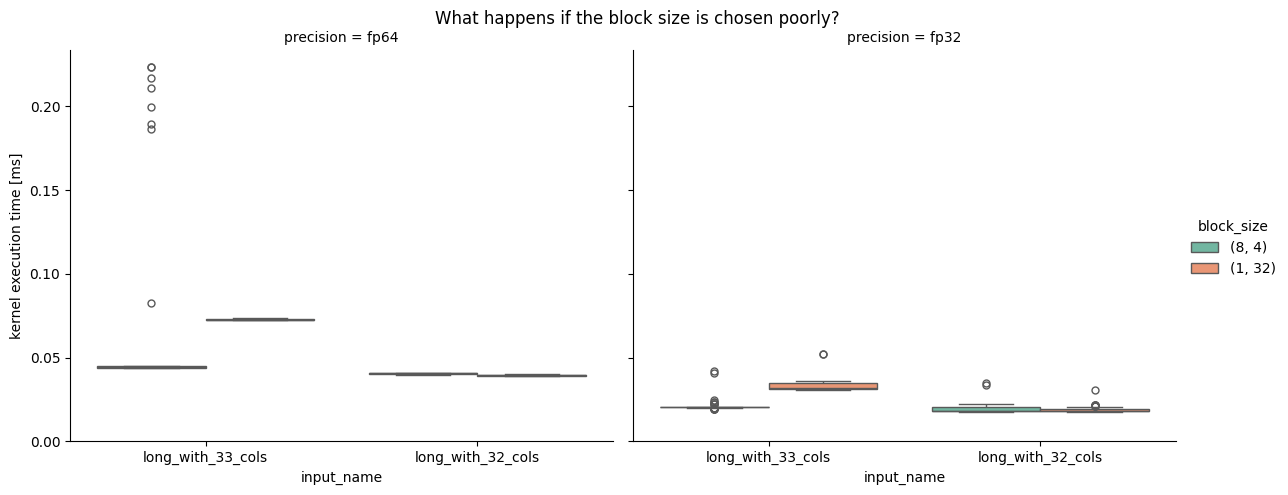

In [16]:
g = sns.catplot(
    data=results,
    x="input_name",
    y="kernel execution time [ms]",
    hue="block_size",
    col="precision",
    kind="box",
    height=5,
    aspect=1.2,
    palette="Set2"
)
plt.ylim((0, None))
plt.suptitle("What happens if the block size is chosen poorly?")
plt.subplots_adjust(top=0.9)
plt.show()

Im obigen Plot können nun die Kernel Execution Times in abgängigkeit des Inputs (U, S, VT), Präzision (FP32 / FP64) und Block Size entnommen werden.

Im linken Subplot sind die Resultate des FP64 Kernels zu sehen. Bei der Input Matrix mit 33 Spalten *long_with_33_cols* zeigt sich ein signifikanter Geschwindigkeitsunterschied ob die Blockgrösse von (8, 4) oder (1, 32) verwendet wird, obwohl beide genau ein Warp füllen können. Die Rekonstruktion mit der Blockgrösse (8, 4) ist deutlich schneller als (1, 32). Dies liegt sehr wahrscheinlich daran, dass bei (1, 32) die Threads in einem Warp teilweise nichts machen und somit für weitere Berechnungen blockiert werden.

Bei *long_with_32_cols* zeigt sich zwischen den beiden Blockgrössen kein signifikanter Geschwindigkeitsunterschied. Dies weil bei dieser Matrix eine komplette Zeile in einem Warp berechnet werden kann und somit der Blockgrösse (1, 32) praktisch ideal ist für diese Matrix.

Das gleiche Muster zeigt sich auf der rechten Seite bei den FP32 Kernels. Gegenüber den FP64 Kernels sind diese allerdings nochmals etwas schneller, da auf einer RTX 4090 mehr FP32 Operationen pro Sekunde durchgeführt werden können als FP64 Operationen.

##### Performance von verschiedenen Blockgrössen auf verschiedenen Inputs

In [17]:
from src.utils import (
    get_n_timings_from_inputs_and_kernels, 
    make_reconstructor, 
    block_sizes_from_threadcount, 
    sparse_out_block_sizes, 
    reconstruct_svd_broadcast_timeit_fp64, 
    reconstruct_svd_broadcast_timeit_fp32
)
from src.kernels.global_mem import fp32 as kernel_globalmem_fp32
from src.kernels.global_mem import fp64 as kernel_globalmem_fp64

In [18]:
# generate all possible block sizes which contain a multiple of 32 threads
block_sizes = block_sizes_from_threadcount(32) + block_sizes_from_threadcount(64) + block_sizes_from_threadcount(128) + block_sizes_from_threadcount(256) + block_sizes_from_threadcount(512)

# only select 5 or 4 block sizes per 32 multiple
block_sizes = sparse_out_block_sizes(block_sizes, 5)

block_sizes

[(1, 32),
 (4, 8),
 (8, 4),
 (32, 1),
 (1, 64),
 (4, 16),
 (8, 8),
 (16, 4),
 (64, 1),
 (2, 64),
 (8, 16),
 (16, 8),
 (64, 2),
 (2, 128),
 (8, 32),
 (16, 16),
 (32, 8),
 (128, 2),
 (1, 512),
 (4, 128),
 (16, 32),
 (32, 16),
 (128, 4),
 (512, 1)]

Als erstes habe ich nun verschiedene Blockgrössen erstellt. Alle Grössen besitzen ein Vielfaches von 32 als Anzahl Threads. Ich habe das so gewählt, weil somit alle Blöcke komplett in Warps eingeteilt werden können. Ich habe die Blockgrössen für den Threadcount auf 32, 64, 128, 256 und 512 begrenzt, damit ich nicht ewig rechnen und analysieren muss. Ausserdem habe ich für jeden Threadcount 4-5 Blockgrössen selektiert.

In [19]:
reco_funcs_fp64 = [make_reconstructor(kernel_globalmem_fp64, bs, timeit=True) for bs in block_sizes]
reco_names_fp64 = [str(bs) + "_fp64" for bs in block_sizes]

reco_funcs_fp32 = [make_reconstructor(kernel_globalmem_fp32, bs, timeit=True) for bs in block_sizes]
reco_names_fp32 = [str(bs) + "_fp32" for bs in block_sizes]

reco_funcs_cpu = [reconstruct_svd_broadcast_timeit_fp64, reconstruct_svd_broadcast_timeit_fp32]
reco_names_cpu = ["cpu_fp64", "cpu_fp32"]

reco_funcs = reco_funcs_fp64 + reco_funcs_fp32 + reco_funcs_cpu
reco_names = reco_names_fp64 + reco_names_fp32 + reco_names_cpu

Nun wurden die Rekonstruktionsfunktionen für die einzelnen Blockgrössen erstellt.

In [20]:
inputs = [matrices["tiny"], matrices["small"], matrices["medium"], matrices["large"], matrices["quadratic"]]
inputs_names = ["tiny", "small", "medium", "large", "quadratic"]

Und nun wurden die inputs vorbereitet

In [21]:
results = get_n_timings_from_inputs_and_kernels(inputs, reco_funcs, inputs_names, reco_names, n=20)

results["precision"] = results["reco_name"].str.split("_").apply(lambda x: x[1])
results["block_size"] = results["reco_name"].str.split("_").apply(lambda x: x[0]).apply(lambda x: tuple((eval(x)[0], eval(x)[1])) if x != "cpu" else "cpu")
results["num threads"] = results["block_size"].map(lambda x: x[0]*x[1] if x != "cpu" else None)
results["block orient"] = results["block_size"].map(lambda x: ("horizontal" if x[0]<x[1] else "vertical" if x[0]>x[1] else "quadratic") if x != "cpu" else None)
results["mem type"] = "global"

results["h2d trans. [ms]"] = results["h2d"] * 1000
results["device maloc y [ms]"] = results["d_maloc_y"] * 1000
results["host maloc y [ms]"] = results["h_maloc_y"] * 1000
results["kernel exec [ms]"] = results["kernel"] * 1000
results["d2h trans. [ms]"] = results["d2h"] * 1000
results["total mem. ops [ms]"] = results["mem_operations_total"] * 1000
results["total time [ms]"] = results["total"] * 1000

In [22]:
results_median = results.groupby(["input_name", "precision", "block_size"]).median(numeric_only=True).reset_index()

results_median.head()

,input_name,precision,block_size,h2d,d_maloc_y,h_maloc_y,kernel,d2h,mem_operations_total,total,repeat,num threads,h2d trans. [ms],device maloc y [ms],host maloc y [ms],kernel exec [ms],d2h trans. [ms],total mem. ops [ms],total time [ms]
0,large,fp32,"(1, 32)",0.041591,0.000002,0.000002,0.207481,0.022692,0.064360,0.272086,9.5,32.0,41.591230,0.002048,0.001664,207.480827,22.691521,64.360048,272.086476
1,large,fp32,"(1, 64)",0.041272,0.000002,0.000002,0.202643,0.022690,0.064058,0.266904,9.5,64.0,41.271599,0.002048,0.001680,202.643456,22.690432,64.058239,266.903839
2,large,fp32,"(1, 512)",0.041505,0.000002,0.000001,0.197699,0.022852,0.064361,0.262271,9.5,512.0,41.504766,0.002048,0.001024,197.698944,22.852448,64.360881,262.271110
3,large,fp32,"(2, 64)",0.041278,0.000002,0.000002,0.193921,0.022749,0.064140,0.257832,9.5,128.0,41.278463,0.001904,0.001744,193.920517,22.748560,64.139727,257.832333
4,large,fp32,"(2, 128)",0.041753,0.000002,0.000002,0.189615,0.022655,0.064298,0.254112,9.5,256.0,41.753456,0.002048,0.001776,189.614517,22.654961,64.297904,254.112355


Nun wurden die einzelnen Kernels auf der GPU (und zum Vergleich auch auf der CPU) auf den inputs angewendet. Die Rekonstruktionen wurden 20mal pro Setting durchgeführt.

Zum Dataframe wurden noch folgende Felder hinzugefügt:
- *precision*: Wurde die Berechnung mit FP64 oder FP32 Präzision durchgeführt?
- *block_size*: Blockgrösse als Tuple oder 'cpu'
- *num threads*: Anzahl Threads in einem Block oder None
- *block orient*: Block Orientation (mehr Zeilen als Spalten -> Vertikal; mehr Spalten als Zeilen -> Horizontal; gleichviele Zeilen wie Spalten -> Quadratisch). Bei CPU ist das Feld None
- *mem type*: Typ von Memory welche im Kernel benutzt wurde (Shared/Global)

Zusätzlich wurde noch der Median der einzelnen Runs auf dem gleichen Setting berechnet.

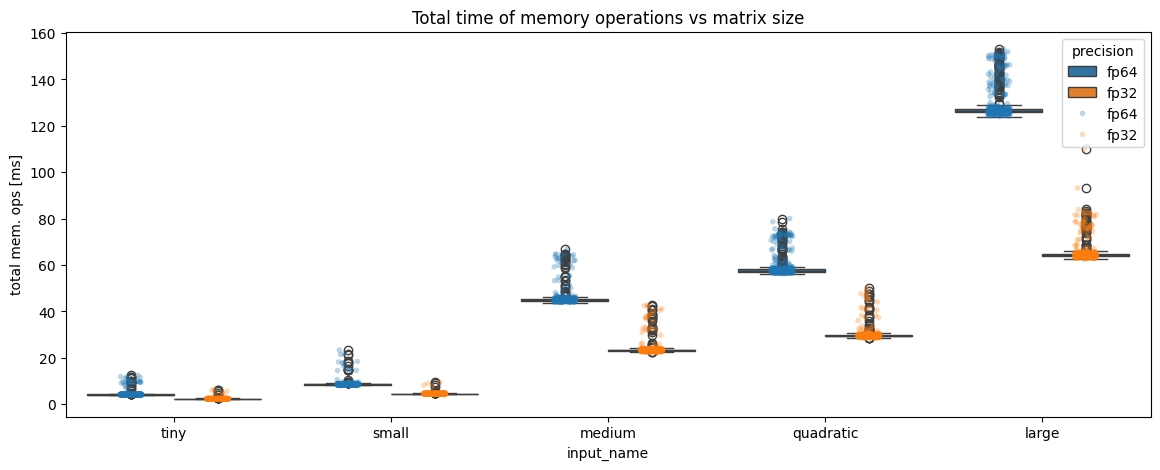

In [23]:
plt.figure(figsize=(14, 5))
sns.boxplot(
    results,
    x="input_name",
    y="total mem. ops [ms]",
    hue="precision",
    order=["tiny", "small", "medium", "quadratic", "large"]
)
sns.stripplot(
    results,
    x="input_name",
    y="total mem. ops [ms]",
    hue="precision",
    order=["tiny", "small", "medium", "quadratic", "large"],
    dodge=True,
    alpha=0.3,
    size=4
)
plt.title("Total time of memory operations vs matrix size")
plt.show()

Im oberen Diagramm ist die aufsummierte Zeit für die Speicheroperationen (Memory Operations) dargestellt.

Wie zu erkennen ist, bleibt die Dauer der Memory Operations bei gleichen Einstellungen und identischen Eingabedaten, abgesehen von leichten Zufallsschwankungen, weitgehend konstant. Daraus lässt sich schliessen, dass die Datenübertragung zwischen CPU und GPU nicht von der Blockgrösse abhängt, was plausibel ist.

Allerdings hat die Grösse der Eingabedaten sehr wohl einen Einfluss (mehr Daten bzw grössere Matrizen resultiert in einer längeren Übertragungszeit zwischen Host und GPU). Ebenso spielt die verwendete Genauigkeit (FP64 vs. FP32) eine Rolle. Bei FP32 ist die Übertragungszeit geringer, grob etwa halb so gross wie bei FP64. Bei sehr kleinen Matrizen (z. B. *tiny*) fällt der Unterschied jedoch geringer aus, was darauf hindeutet, dass hier noch zusätzlicher Overhead beim Speichertransfer anfällt.

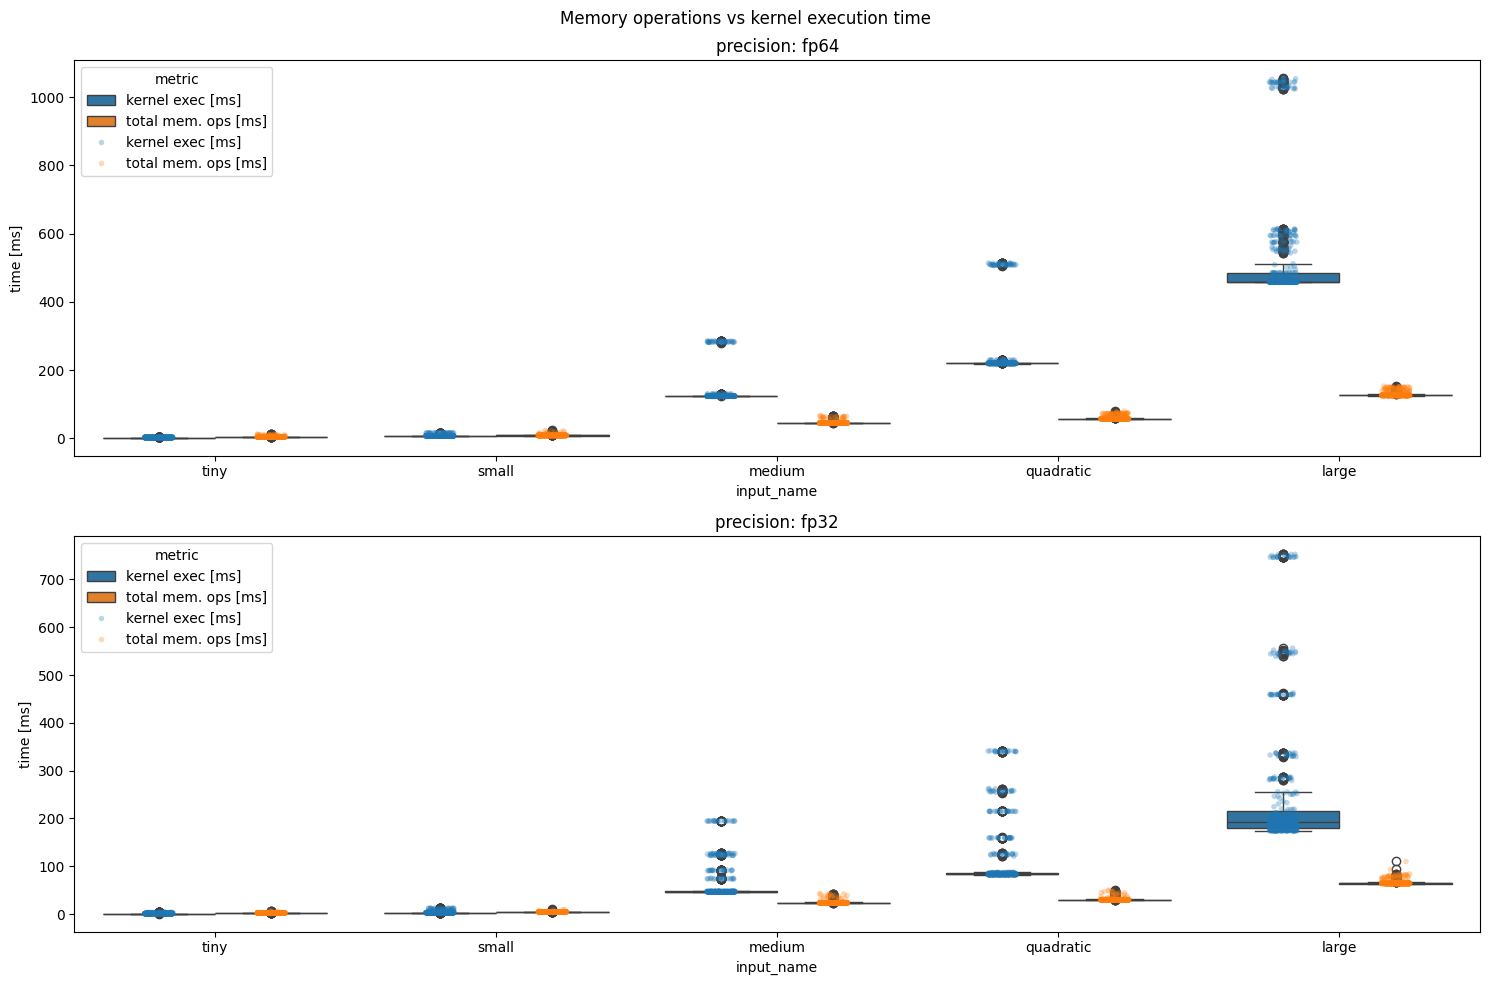

In [24]:
df = results[["precision", "block_size", "input_name", "kernel exec [ms]", "total mem. ops [ms]"]].melt(["precision", "block_size", "input_name"], var_name="metric", value_name="time [ms]").reset_index()

_, axes = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(
    df.query("precision == 'fp64'"),
    x="input_name",
    y="time [ms]",
    hue="metric",
    order=["tiny", "small", "medium", "quadratic", "large"],
    ax=axes[0]
)
sns.stripplot(
    df.query("precision == 'fp64'"),
    x="input_name",
    y="time [ms]",
    hue="metric",
    order=["tiny", "small", "medium", "quadratic", "large"],
    dodge=True,
    alpha=0.3,
    size=4,
    ax=axes[0]
)
axes[0].set_title("precision: fp64")


sns.boxplot(
    df.query("precision == 'fp32'"),
    x="input_name",
    y="time [ms]",
    hue="metric",
    order=["tiny", "small", "medium", "quadratic", "large"],
    ax=axes[1]
)
sns.stripplot(
    df.query("precision == 'fp32'"),
    x="input_name",
    y="time [ms]",
    hue="metric",
    order=["tiny", "small", "medium", "quadratic", "large"],
    dodge=True,
    alpha=0.3,
    size=4,
    ax=axes[1]
)
axes[1].set_title("precision: fp32")

plt.suptitle("Memory operations vs kernel execution time")
plt.tight_layout()
plt.show()

Im gezeigten Diagramm werden die Kernel-Ausführungszeiten den Speicheroperationen (Memory Operations) gegenübergestellt. Zu Beginn ist der Memory-Overhead bei beiden Genauigkeiten (FP32 und FP64) noch kleiner als die reine Kernelzeit. Mit wachsender Matrixgrösse steigen jedoch die Übertragungszeiten, sodass der Speichertransfer zunehmend ins Gewicht fällt. Daher ist es wichtig, diesen Aspekt in die Gesamtbetrachtung mit einzubeziehen, da je nach Task dieser dazu führen kann, dass die Berechnung auf der GPU länger geht als auf der CPU.

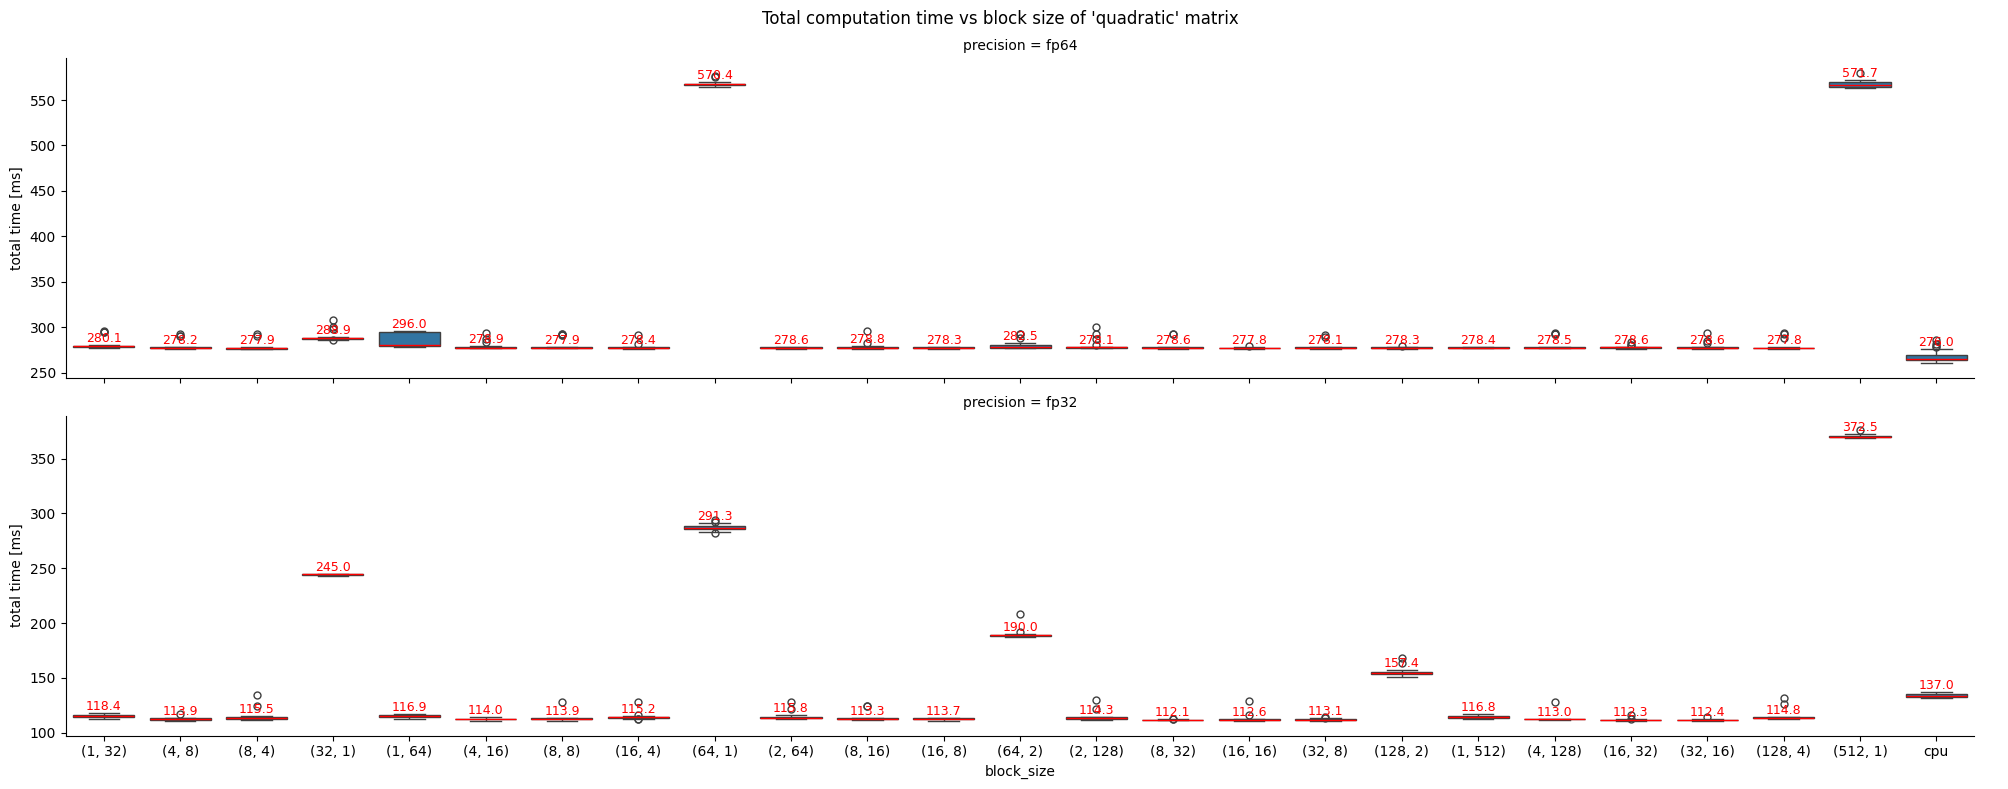

In [25]:
df_quad = results.query("input_name == 'quadratic'")

g = sns.catplot(
    data=df_quad,
    row="precision",
    x="block_size",
    y="total time [ms]",
    sharey=False,
    kind="box",
    height=4,
    aspect=5,
    medianprops={'color': 'red', 'linewidth': 1}
)

for ax in g.axes.flat:    
    categories = ax.get_xticks() 
    n_cats = len(categories)

    for i in range(n_cats):
        q3_line = ax.lines[3 + i*6]
        q3_y = q3_line.get_ydata()
        q3_val = q3_y[0] 

        ax.text(
            i,                    
            q3_val,          
            f"{q3_val:.1f}",  
            ha='center',
            va='bottom',
            color='red',
            fontsize=9
        )

plt.suptitle("Total computation time vs block size of 'quadratic' matrix")
plt.subplots_adjust(top=0.92)
plt.show()

Im obigen Plot sind die verschiedenen Berechnungszeiten für die quadratische Matrix dargestellt. Auf der x-Achse sind die unterschiedlichen Blockgrössen sowie die CPU-Variante aufgeführt. Je kleiner die *total time*, desto besser das Ergebnis.

Ein auffälliges Muster sind einzelne Boxen, deren Werte stark nach oben ausbrechen. Dieses Phänomen tritt besonders deutlich bei 32-Bit-Präzision (FP32) auf. In diesen Fällen ist die Anzahl der Spalten deutlich geringer als die Anzahl der Zeilen. Dies deutet darauf hin, dass der Zugriff auf das Global Memory bei diesen Blockgrössen ineffizient ist, da wahrscheinlich kein effizientes Memory-Coalescing stattfinden kann. Dadurch entstehen längere Zugriffszeiten auf den Speicher, was sich letztlich negativ auf die Berechnungszeit auswirkt. Die Auswirkungen sind bei FP32 vermutlich ausgeprägter, da Berechnungen mit FP32 schneller durchgeführt werden als mit FP64 und der Speicherzugriff somit relativ stärker ins Gewicht fällt.

Dieses Muster zeigt sich auch bei anderen Matrizen. Aus Platzgründen habe ich deren Visualisierungen weggelassen.

Für die weiteren Analysen werde ich daher "vertikale" Blockgrössen ausschliessen.

In [26]:
results_novertical = results.query("`block orient` in ['horizontal', 'quadratic', None]") # remove all vertical 

c:\Users\Stephan\AppData\Local\pypoetry\Cache\virtualenvs\hpc-mc2-buesst1-d94spYeM-py3.11\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


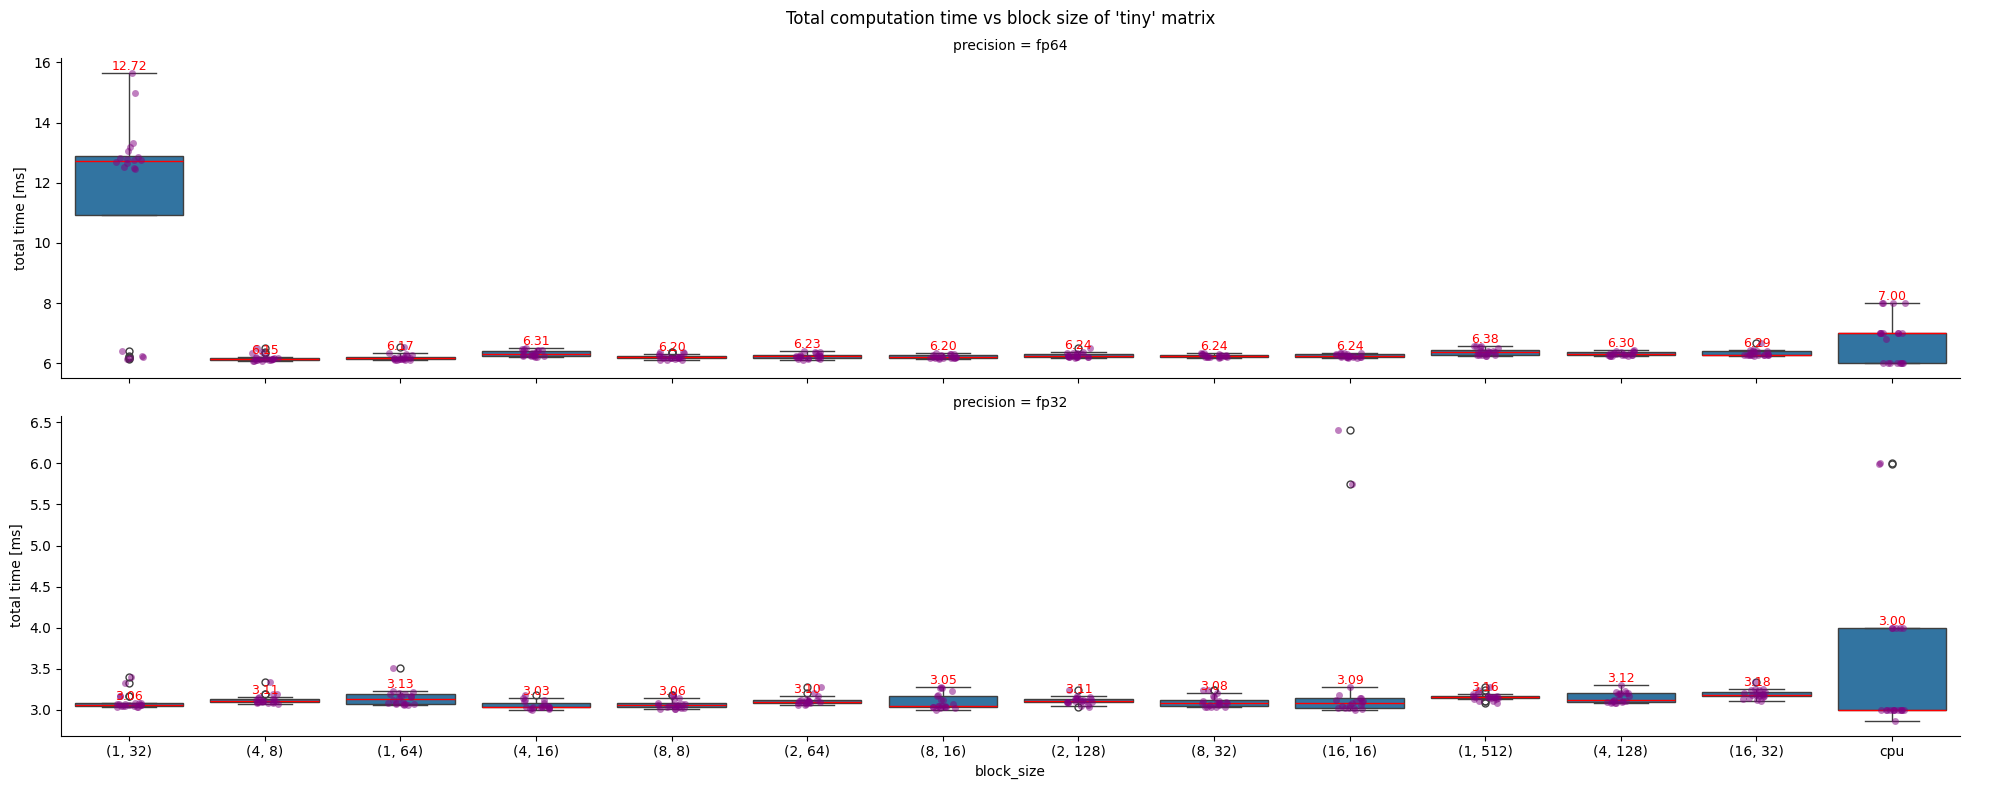

In [27]:
matrix_name = "tiny"

df = results_novertical.query(f"input_name == '{matrix_name}'")

g = sns.catplot(
    data=df,
    row="precision",
    x="block_size",
    y="total time [ms]",
    sharey=False,
    kind="box",
    height=4,
    aspect=5,
    medianprops={'color': 'red', 'linewidth': 1} 
)

g.map(sns.stripplot, "block_size", "total time [ms]", color="purple", alpha=0.5)

for ax in g.axes.flat:    
    categories = ax.get_xticks() 
    n_cats = len(categories)

    for i in range(n_cats):
        q3_line = ax.lines[3 + i*6]
        q3_y = q3_line.get_ydata()
        q3_val = q3_y[0] 

        median_line = ax.lines[4 + i*6]
        median_y = median_line.get_ydata()
        median_val = median_y[0]  # z. B. 5.3

        ax.text(
            i,                    
            q3_val,          
            f"{median_val:.2f}",  
            ha='center',
            va='bottom',
            color='red',
            fontsize=9
        )

plt.suptitle(f"Total computation time vs block size of '{matrix_name}' matrix")
plt.subplots_adjust(top=0.92)
plt.show()

Für die kleinste Matrix zeigt sich, dass die Blockgrösse keinen merklichen Einfluss auf die Gesamtberechnungszeit hat. Möglicherweise sind kleinere Unterschiede aufgrund von Mess-Overheads nicht sauber zu erfassen.  
Nach den Messungen liegt die GPU (bei FP64) etwa auf demselben Niveau wie die CPU; bei FP32 zeigt sich ein ähnliches Bild, allerdings ist hier die CPU sogar etwas schneller.  

Für so kleine Matrizen würde ich daher eher die CPU empfehlen, da der Aufwand für den Aufbau geringer ist und die Berechnung in der Praxis vermutlich schneller abläuft.

c:\Users\Stephan\AppData\Local\pypoetry\Cache\virtualenvs\hpc-mc2-buesst1-d94spYeM-py3.11\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


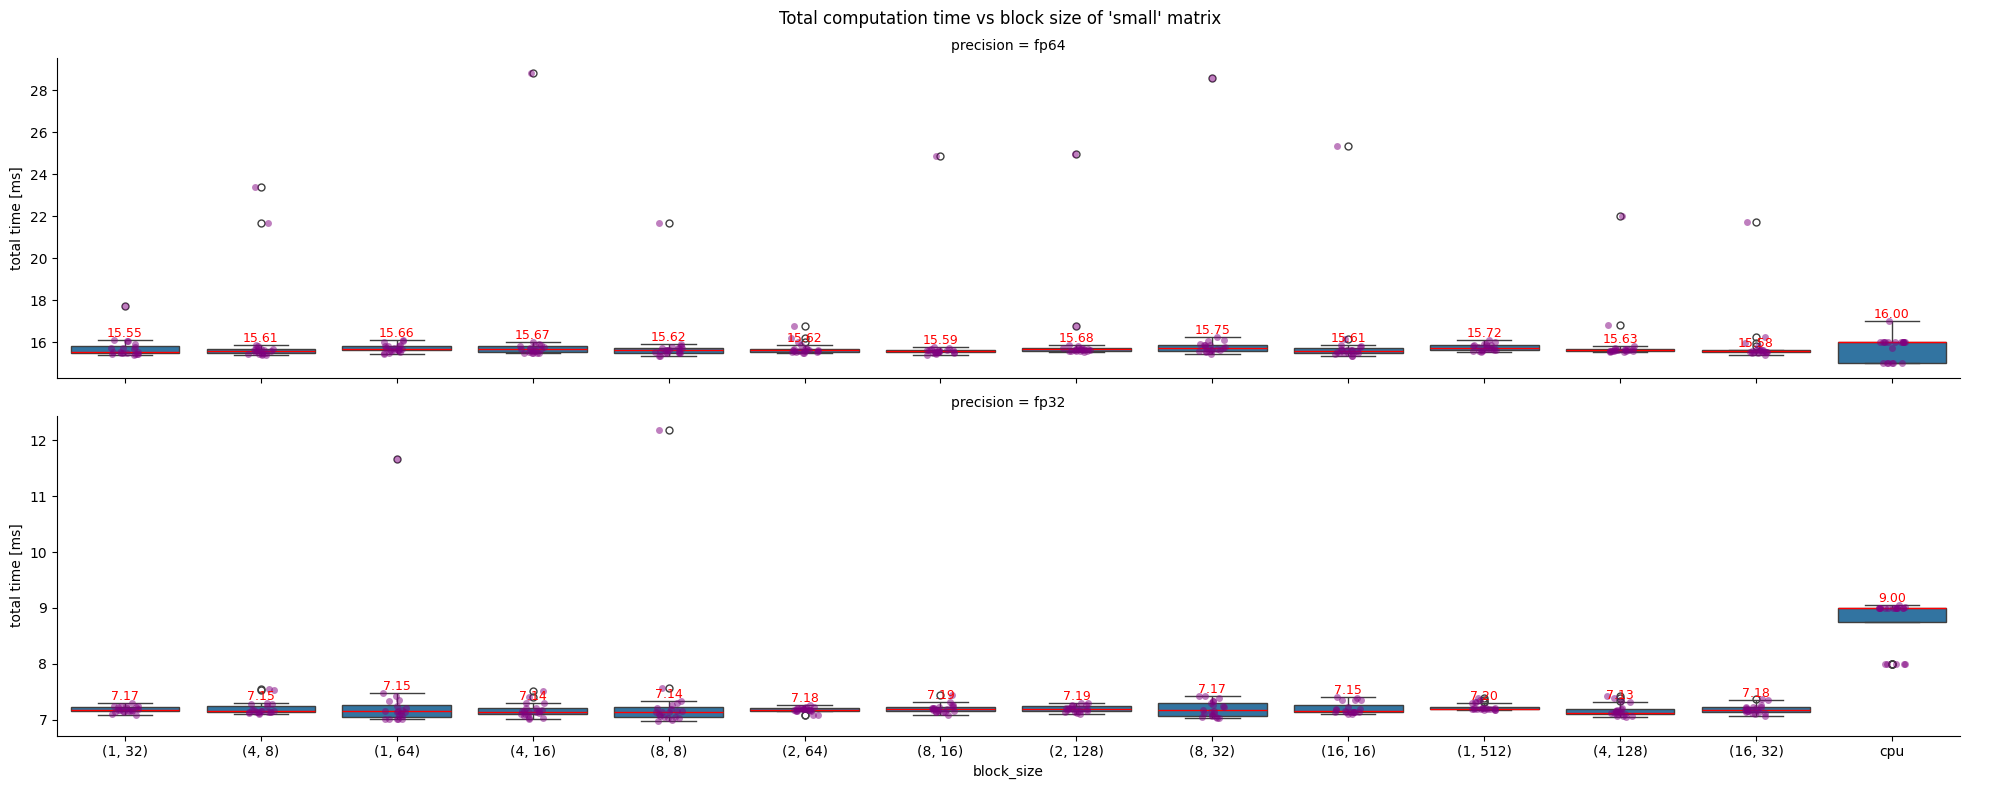

In [28]:
matrix_name = "small"

df = results_novertical.query(f"input_name == '{matrix_name}'")

g = sns.catplot(
    data=df,
    row="precision",
    x="block_size",
    y="total time [ms]",
    sharey=False,
    kind="box",
    height=4,
    aspect=5,
    medianprops={'color': 'red', 'linewidth': 1} 
)

g.map(sns.stripplot, "block_size", "total time [ms]", color="purple", alpha=0.5)

for ax in g.axes.flat:    
    categories = ax.get_xticks() 
    n_cats = len(categories)

    for i in range(n_cats):
        q3_line = ax.lines[3 + i*6]
        q3_y = q3_line.get_ydata()
        q3_val = q3_y[0] 

        median_line = ax.lines[4 + i*6]
        median_y = median_line.get_ydata()
        median_val = median_y[0]  # z. B. 5.3

        ax.text(
            i,                    
            q3_val,          
            f"{median_val:.2f}",  
            ha='center',
            va='bottom',
            color='red',
            fontsize=9
        )

plt.suptitle(f"Total computation time vs block size of '{matrix_name}' matrix")
plt.subplots_adjust(top=0.92)
plt.show()

Auch bei der kleinen Matrix sind keine nennenswerten Performanceunterschiede zwischen den verschiedenen Kerneln zu beobachten. Auffällig ist jedoch, dass die CPU bei FP64 schneller rechnet als die GPU, während sich bei FP32 ein anderes Bild zeigt. Hier ist die GPU bei allen Blockgrössen im Vorteil. Auch hinsichtlich der Blockgrösse selbst lassen sich keine signifikanten Unterschiede in der Rechenleistung erkennen.

c:\Users\Stephan\AppData\Local\pypoetry\Cache\virtualenvs\hpc-mc2-buesst1-d94spYeM-py3.11\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


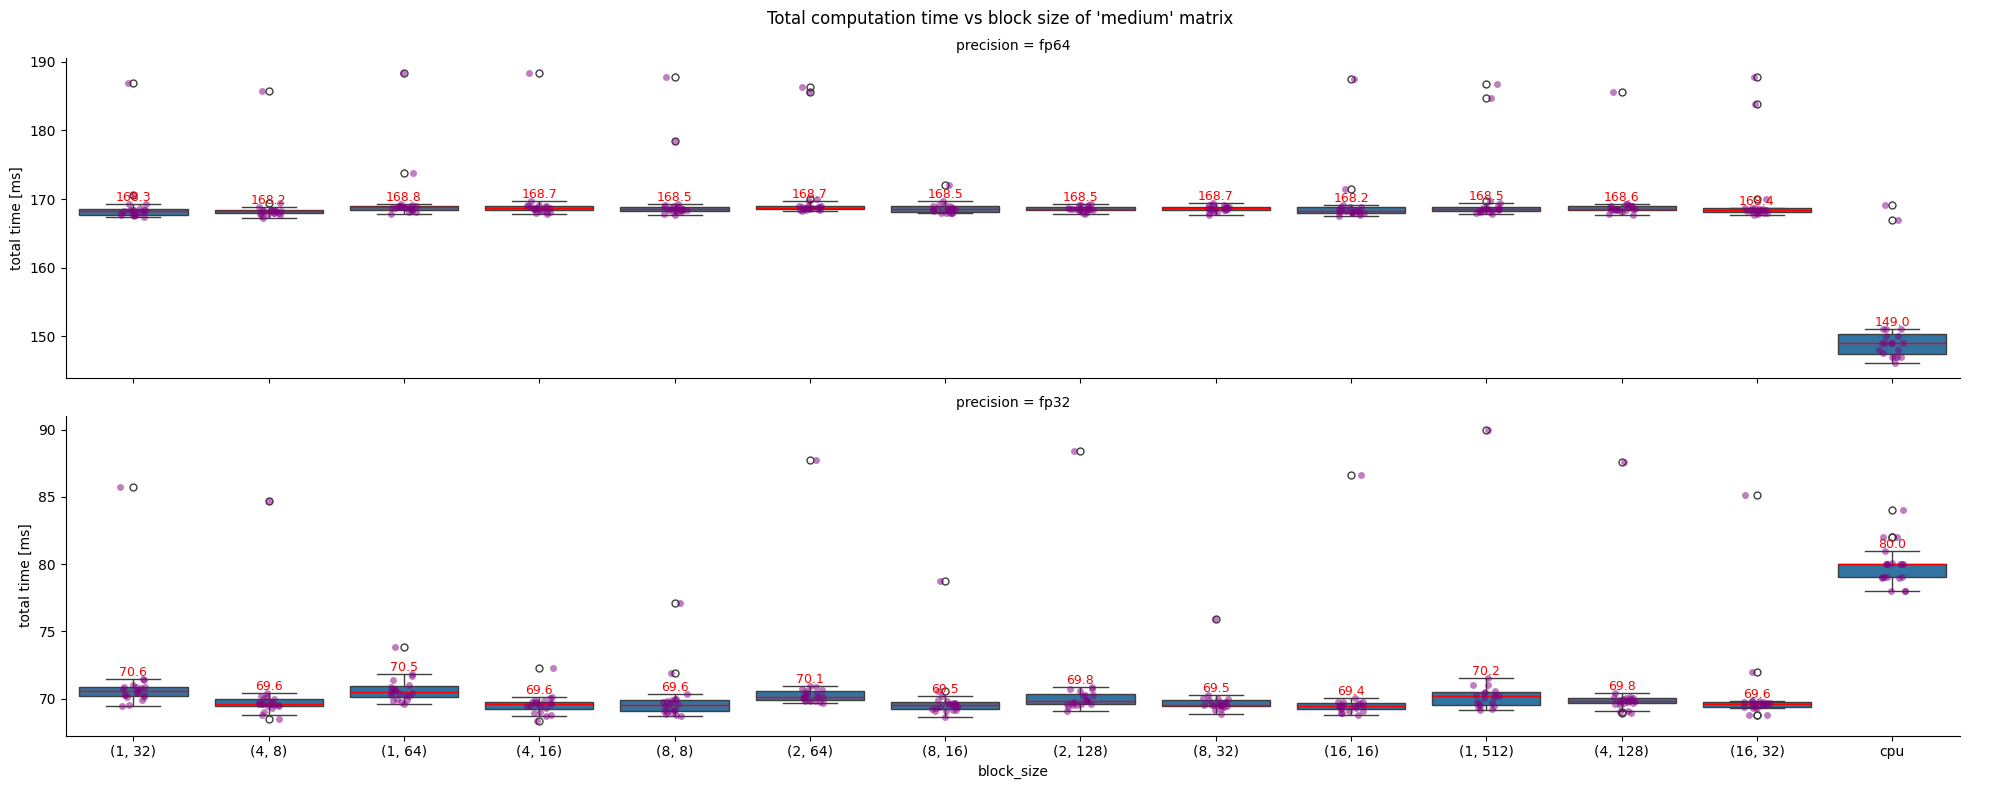

In [29]:
matrix_name = "medium"

df = results_novertical.query(f"input_name == '{matrix_name}'")

g = sns.catplot(
    data=df,
    row="precision",
    x="block_size",
    y="total time [ms]",
    sharey=False,
    kind="box",
    height=4,
    aspect=5,
    medianprops={'color': 'red', 'linewidth': 1} 
)

g.map(sns.stripplot, "block_size", "total time [ms]", color="purple", alpha=0.5)

for ax in g.axes.flat:    
    categories = ax.get_xticks() 
    n_cats = len(categories)

    for i in range(n_cats):
        q3_line = ax.lines[3 + i*6]
        q3_y = q3_line.get_ydata()
        q3_val = q3_y[0] 

        median_line = ax.lines[4 + i*6]
        median_y = median_line.get_ydata()
        median_val = median_y[0]  # z. B. 5.3

        ax.text(
            i,                    
            q3_val,          
            f"{median_val:.1f}",  
            ha='center',
            va='bottom',
            color='red',
            fontsize=9
        )

plt.suptitle(f"Total computation time vs block size of '{matrix_name}' matrix")
plt.subplots_adjust(top=0.92)
plt.show()

Auch bei der mittelgrossen Matrix fallen im FP64-Fall keine nennenswerten Performanceunterschiede zwischen den verschiedenen Blockgrössen auf. Allerdings war hier die CPU erneut signifikant schneller als die GPU. Betrachtet man hingegen FP32, so liegt die GPU bei allen Blockgrössen weiterhin vor der CPU. Jedoch beginnen sich nun leichte Unterschiede zwischen den Blockgrössen abzuzeichnen.

Insbesondere Varianten wie (1, 32), (2, 64) oder (1, 512) sind etwas langsamer. Das könnte daran liegen, dass zu viele kleine Blöcke gestartet werden und somit alle SM's mit zu kleinen Tasks gefüllt wird. Dadurch müssen zu viele Blöcke mit jeweils wenig Rechenoperationen bearbeitet werden und der dadurch erzeuge Overhead macht die Berechnung wahrscheinlich langsamer. Gleichzeitig können Threads in Randbereichen der Matrix inaktiv bleiben und so Recheneinheiten blockieren, die anderen Blöcken zur Verfügung stehen könnten.

Quadratische oder ausgewogen dimensionierte Blockgrössen wie (8, 8), (16, 16), (4, 8), (8, 16) oder (16, 32) zeigen hingegen eine gleichmässigere Performance. Wahrscheinlich liegt das daran, dass sich die Threads besser auf die GPU verteilen lassen und am Rand der Matrix weniger Ressourcen ungenutzt bleiben. Dadurch verringert sich der Start‐Overhead pro Block, und die GPU kann ihre Rechenkapazität effizienter ausschöpfen.

c:\Users\Stephan\AppData\Local\pypoetry\Cache\virtualenvs\hpc-mc2-buesst1-d94spYeM-py3.11\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


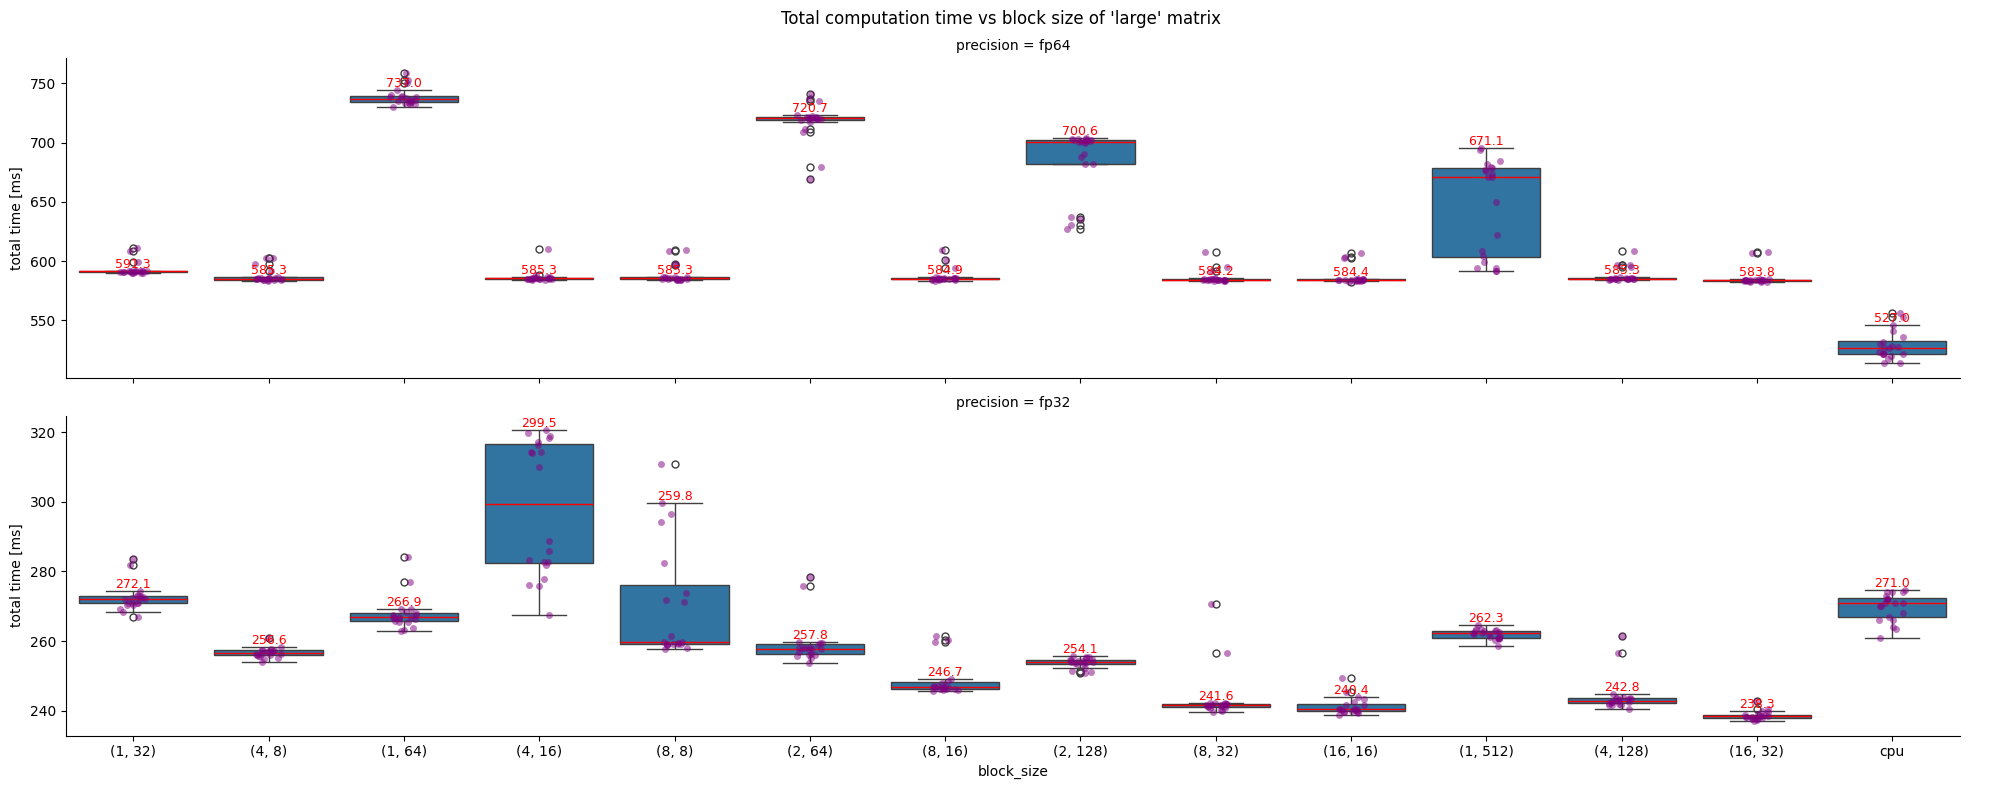

In [30]:
matrix_name = "large"

df = results_novertical.query(f"input_name == '{matrix_name}'")

g = sns.catplot(
    data=df,
    row="precision",
    x="block_size",
    y="total time [ms]",
    sharey=False,
    kind="box",
    height=4,
    aspect=5,
    medianprops={'color': 'red', 'linewidth': 1} 
)

g.map(sns.stripplot, "block_size", "total time [ms]", color="purple", alpha=0.5)

for ax in g.axes.flat:    
    categories = ax.get_xticks() 
    n_cats = len(categories)

    for i in range(n_cats):
        q3_line = ax.lines[3 + i*6]
        q3_y = q3_line.get_ydata()
        q3_val = q3_y[0] 

        median_line = ax.lines[4 + i*6]
        median_y = median_line.get_ydata()
        median_val = median_y[0]  # z. B. 5.3

        ax.text(
            i,                    
            q3_val,          
            f"{median_val:.1f}",  
            ha='center',
            va='bottom',
            color='red',
            fontsize=9
        )

plt.suptitle(f"Total computation time vs block size of '{matrix_name}' matrix")
plt.subplots_adjust(top=0.92)
plt.show()

Auch bei der grössten Matrix zeigt sich ein ähnliches Muster wie im vorherigen Plot, jedoch noch ausgeprägter. Teilweise sind allerdings Phänomene zu beobachten, die sich nicht ohne Weiteres erklären lassen.

Im FP64-Fall bleibt die CPU nach wie vor schneller als die GPU. Ebenso bestätigen sich die zuvor gemachten Beobachtungen zur Blockgrösse. Varianten mit wenigen Zeilen schneiden tendenziell schlechter ab als solche, die mehr Zeilen oder ein ausgeglicheneres Zeilen‐Spalten‐Verhältnis aufweisen.

Bei FP32 treten Effekte auf, die nur schwer zu erklären sind. So liefern Blockdimensionen mit wenigen Zeilen im Verhältnis zu den Spalten eine geringere Performance als stärker ausbalancierte Blöcke. Zusätzlich weisen die Boxplots für (4,16) und (8,8) eine ungewöhnlich grosse Streuung auf. Hierbei könnte es sich um einige ungünstige Ausreisser handeln, die die Boxplots „verbreitern“.

Auffällig ist zudem, dass kleine Blöcke gegenüber Varianten mit vielen Threads schlechter abschneiden. Ein Grund dafür könnte sein, dass die Streaming Multiprozessoren (SMs) der GPU in diesen Fällen nicht genügend ausgelastet werden. Zudem kann der Overhead für das Starten vieler kleiner Blöcke die Performance weiter reduzieren. 

Kernel welche hier (FP32) die Rekonstrukton insgesamt am schnellsten durchführen und damit auch die CPU outperformten besitzen Blöcke mit 256 Threads:
- (8, 32)
- (16, 16)

und 512 Threads:
- (4, 128)
- (16, 32)

**Fazit:**

Bei sehr kleinen Matrizen ist die CPU oft gleich schnell oder sogar schneller als die GPU, insbesondere bei FP64, da der Overhead (zum Beispiel durch Datenübertragung) hier stärker ins Gewicht fällt. Bei grösseren Matrizen kann die GPU ihre Vorteile ausspielen, besonders im FP32-Modus, und erzielt in der Regel klar bessere Ergebnisse als die CPU. Für grössere Eingabedaten empfiehlt es sich, grössere Blockgrössen zu wählen, damit die GPU-Ressourcen optimal ausgelastet sind. Bei kleineren Inputs sind hingegen kleinere Blockgrössen oft passender. Generell zeigen quadratische oder ausgewogene Blockdimensionen eine stabilere Performance, da sie Overheads reduzieren und weniger GPU-Kerne ungenutzt lassen.

Generell zeigt die GPU keinen erheblichen Performance-Boost, auch bei grossen Matrizen nicht. Dies liegt wahrscheinlich an meiner Art und Weise wie die Matrix rekonstruiere. Denn meine Methode ist nicht sehr Rechenaufwenig, da ich keine Matrixmultiplikationen verwende. Dadurch überwiegt der Memory und Launch-Overhead möglicherweise den Performance-Vorteil, welche ich durch die vielen Kerne der GPU erhalte.

##### 5.2.2 Shared Memory auf der GPU
Optimiere deine Implementierung von oben indem du das shared Memory der GPU verwendest. Führe wieder mehrere Experimente mit unterschiedlicher Datengrösse durch und evaluiere den Speedup gegenüber der CPU Implementierung.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplikation und Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

Das Shared Memory der GPU erlaubt uns, oft benötigte Daten effizient zwischenzuspeichern und so die Zahl teurer Global-Memory-Zugriffe zu verringern. In unserem Fall werden die Singulärwerte (die wir bei jeder Berechnung eines Ausgabeelements wiederverwenden) in Kacheln (Tiles) ins Shared Memory geladen und nach Bedarf verarbeitet. Diese Tiling-Strategie ist nötig, weil nicht alle Singulärwerte auf einmal hineinpassen, und sie gewährleistet, dass wir Global-Memory-Zugriffe weitgehend minimieren.

Ich nutze Tiles, damit die Berechnung von grösseren Matrizen auch funktioniert. Falls die Matrix mehr Singulärwerte benötigt als im Shared-Memory platz hätte, so würde die Berechnung nicht mehr funktionieren. Die Tile-Size muss auch so gewält werden, dass das Shared-Memory nicht durch einen ganzen Block besetzt wird. Ansonnsten könnten eventuell nicht mehrere Blöcke gleichzeitig auf einem SM gestartet werden, was auch wieder zu ungenutzten Ressourcen führen könnte.

Deshalb habe ich eine Tile-Size von 256 für FP32 und 128 für FP64 gewählt. Damit würde ein Block immer 1KB Shared-Memory besetzen (256 * 4b für FP32 und 128*8 für FP64).

In [31]:
from src.kernels.shared_mem import fp32 as kernel_sharedmem_fp32
from src.kernels.shared_mem import fp64 as kernel_sharedmem_fp64

In [32]:
u, s, vt = random_svd((5000, 5000))
k = len(s)

reco_func = make_reconstructor(kernel_sharedmem_fp64, (16, 16))

cpu_reconstruction, _ = reconstruct_svd_broadcast_timeit(u, s, vt, k)
gpu_result = reco_func(u,s,vt,k)

np.allclose(cpu_reconstruction, gpu_result)

True

Nochmals testweise überprüfen ob der Kernel funktioniert: Tut er!

In [33]:
reco_funcs_fp64 = [make_reconstructor(kernel_sharedmem_fp64, bs, timeit=True) for bs in block_sizes]
reco_names_fp64 = [str(bs) + "_fp64" for bs in block_sizes]

reco_funcs_fp32 = [make_reconstructor(kernel_sharedmem_fp32, bs, timeit=True) for bs in block_sizes]
reco_names_fp32 = [str(bs) + "_fp32" for bs in block_sizes]

reco_funcs = reco_funcs_fp64 + reco_funcs_fp32 
reco_names = reco_names_fp64 + reco_names_fp32

inputs = [matrices["tiny"], matrices["small"], matrices["medium"], matrices["large"], matrices["quadratic"]]
inputs_names = ["tiny", "small", "medium", "large", "quadratic"]

Nun das gleiche experiment wie oben beim globalmem, allerdings diesmal mit dem shared memory kernel.

In [34]:
results_shmem = get_n_timings_from_inputs_and_kernels(inputs, reco_funcs, inputs_names, reco_names, n=20)

results_shmem["precision"] = results_shmem["reco_name"].str.split("_").apply(lambda x: x[1])
results_shmem["block_size"] = results_shmem["reco_name"].str.split("_").apply(lambda x: x[0]).apply(lambda x: tuple((eval(x)[0], eval(x)[1])) if x != "cpu" else "cpu")
results_shmem["num threads"] = results_shmem["block_size"].map(lambda x: x[0]*x[1] if x != "cpu" else None)
results_shmem["block orient"] = results_shmem["block_size"].map(lambda x: ("horizontal" if x[0]<x[1] else "vertical" if x[0]>x[1] else "quadratic") if x != "cpu" else None)
results_shmem["mem type"] = "shared"

results_shmem["h2d trans. [ms]"] = results_shmem["h2d"] * 1000
results_shmem["device maloc y [ms]"] = results_shmem["d_maloc_y"] * 1000
results_shmem["host maloc y [ms]"] = results_shmem["h_maloc_y"] * 1000
results_shmem["kernel exec [ms]"] = results_shmem["kernel"] * 1000
results_shmem["d2h trans. [ms]"] = results_shmem["d2h"] * 1000
results_shmem["total mem. ops [ms]"] = results_shmem["mem_operations_total"] * 1000
results_shmem["total time [ms]"] = results_shmem["total"] * 1000

Berechnungen und Zeitmessung ausführen (gleich wie bei global memory, aber diesmal ohne cpu).

In [63]:
results_combined = pd.concat([results, results_shmem], ignore_index=True)

Kombiniere beide Resultate.

In [64]:
results_novertical = results_combined.query("`block orient` in ['horizontal', 'quadratic', None]") # remove all vertical 

Alle vertikalen Blockgrössen entfernen

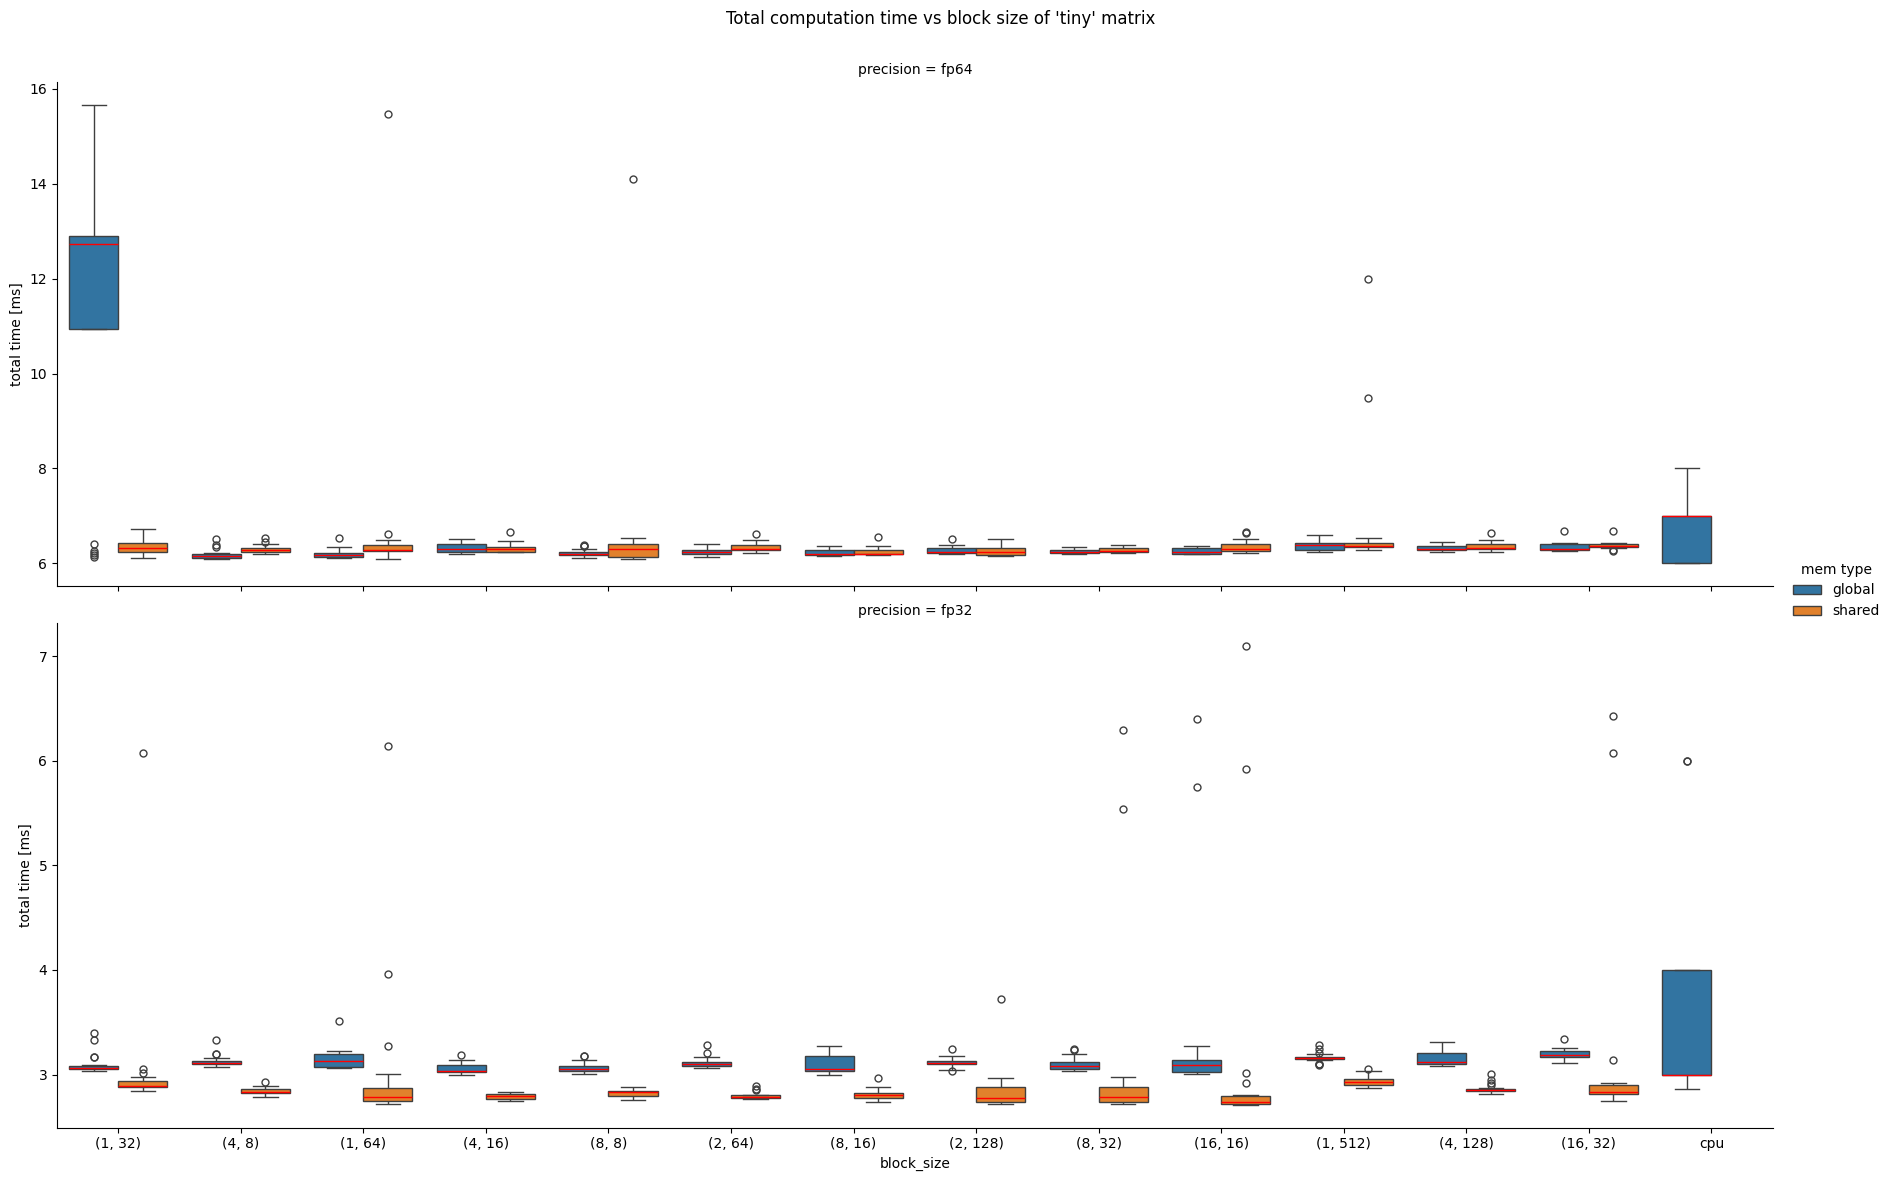

In [79]:
matrix_name = "tiny"

df = results_novertical.query(f"input_name == '{matrix_name}'")

g = sns.catplot(
    data=df,
    row="precision",
    x="block_size",
    y="total time [ms]",
    sharey=False,
    kind="box",
    hue="mem type",
    height=6,
    aspect=3,
    medianprops={'color': 'red', 'linewidth': 1} 
)

plt.suptitle(f"Total computation time vs block size of '{matrix_name}' matrix")
plt.subplots_adjust(top=0.92)
plt.show()

Im obigen Plot sind die gleichen Messungen wie zuvor für den Global-Memory-Ansatz (blau) dargestellt. Zusätzlich sind nun die Ergebnisse des Shared-Memory-Kernels in Orange aufgeführt.

Betrachtet man die FP64-Berechnungen, fällt auf, dass sich im Vergleich kaum ein signifikanter Performance-Unterschied zeigt. Bei FP32 hingegen lässt sich deutlich erkennen, dass der Einsatz von Shared Memory für nahezu alle Blockgrössen einen erheblichen Speedup bewirkt.

Die ausschlaggebende Verbesserung resultiert aus dem erhöhten Data Reuse der Singulärwerte. Da diese Werte nicht ständig aus dem Global Memory oder dem L2-Cache abgerufen werden müssen, sondern direkt aus dem schnelleren L1-Cache verfügbar sind, verkürzen sich die Zugriffszeiten spürbar.

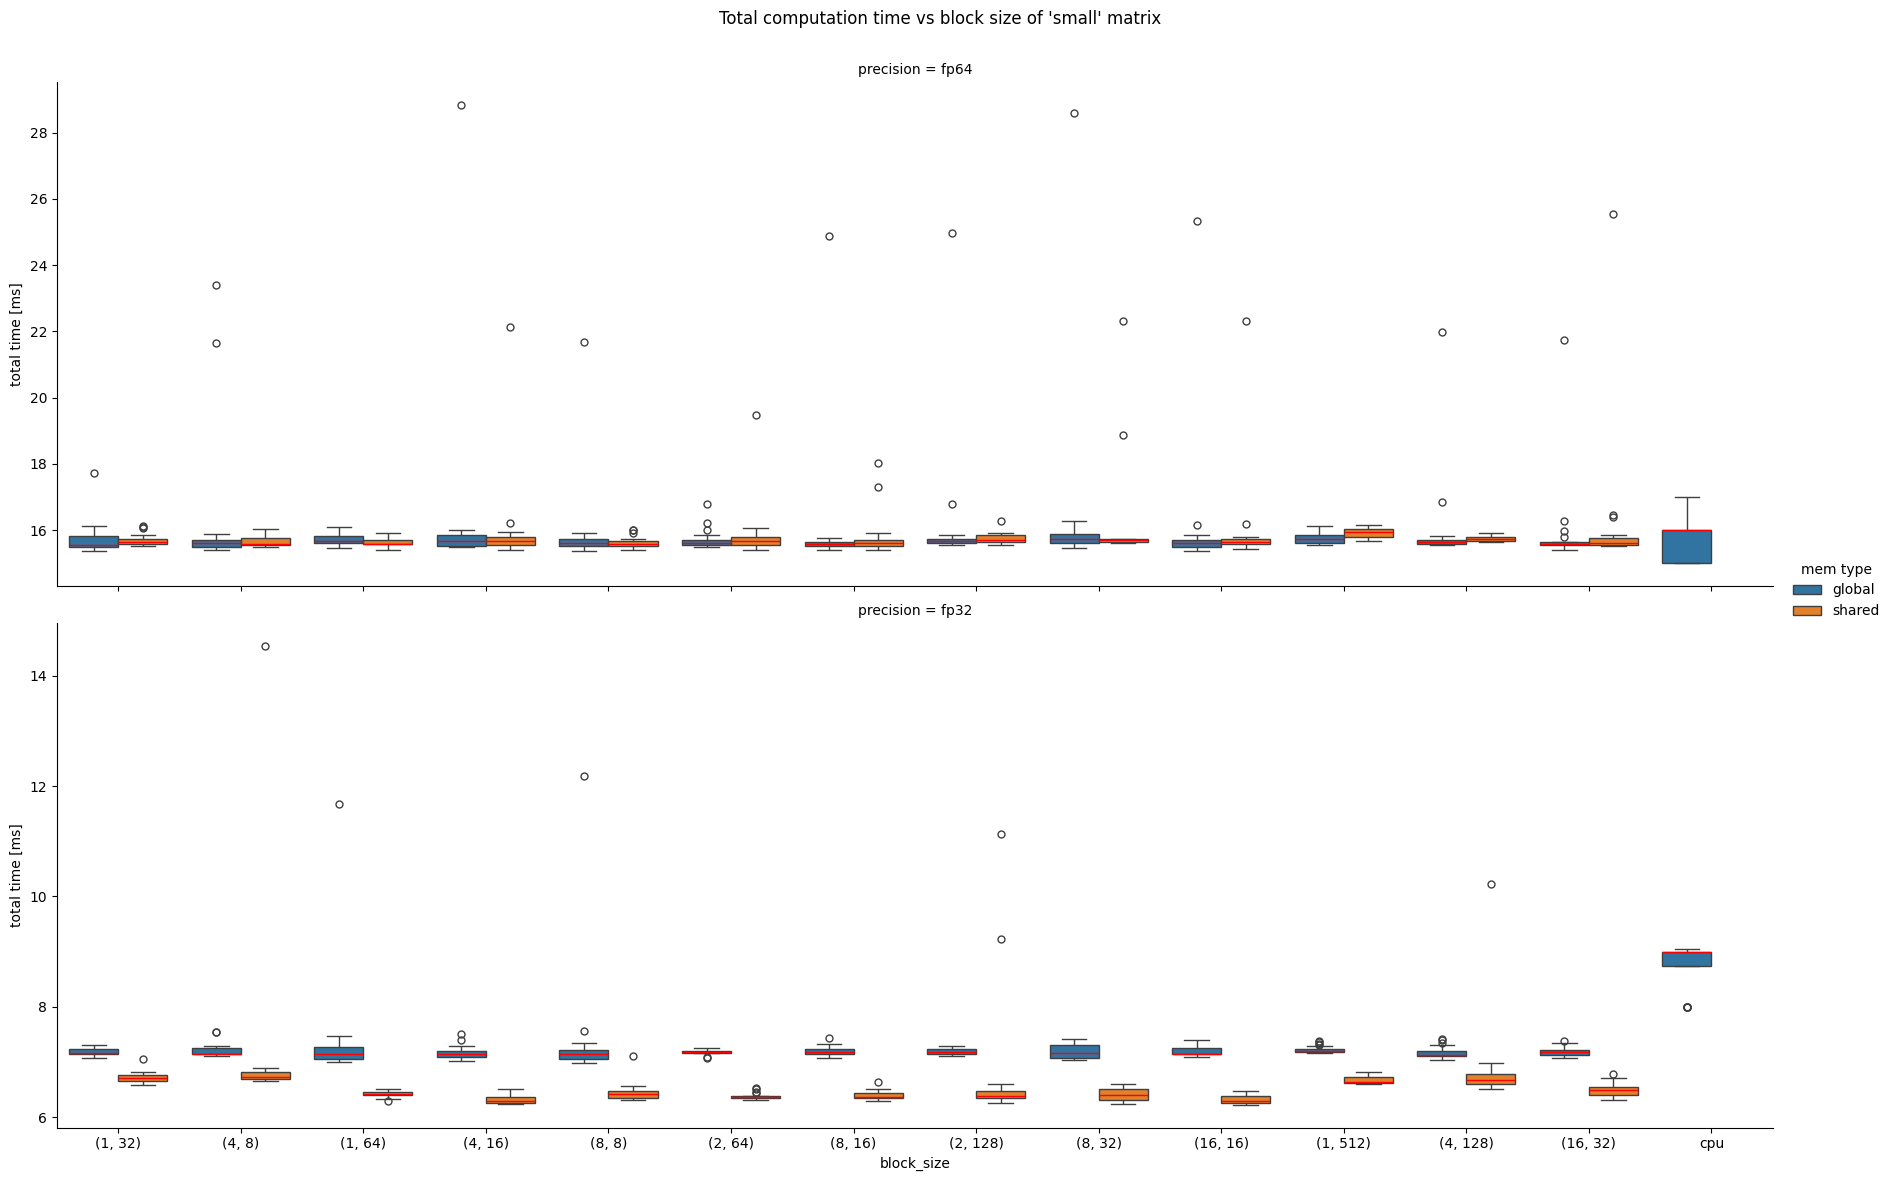

In [80]:
matrix_name = "small"

df = results_novertical.query(f"input_name == '{matrix_name}'")

g = sns.catplot(
    data=df,
    row="precision",
    x="block_size",
    y="total time [ms]",
    sharey=False,
    kind="box",
    hue="mem type",
    height=6,
    aspect=3,
    medianprops={'color': 'red', 'linewidth': 1} 
)

plt.suptitle(f"Total computation time vs block size of '{matrix_name}' matrix")
plt.subplots_adjust(top=0.92)
plt.show()

Auch bei der kleinen Matrix ist bei FP64 keine Verbesserung erkennbar. Im Gegensatz dazu bleibt bei FP32 der durch die Nutzung des Shared Memory erzielte Performancezuwachs deutlich sichtbar.

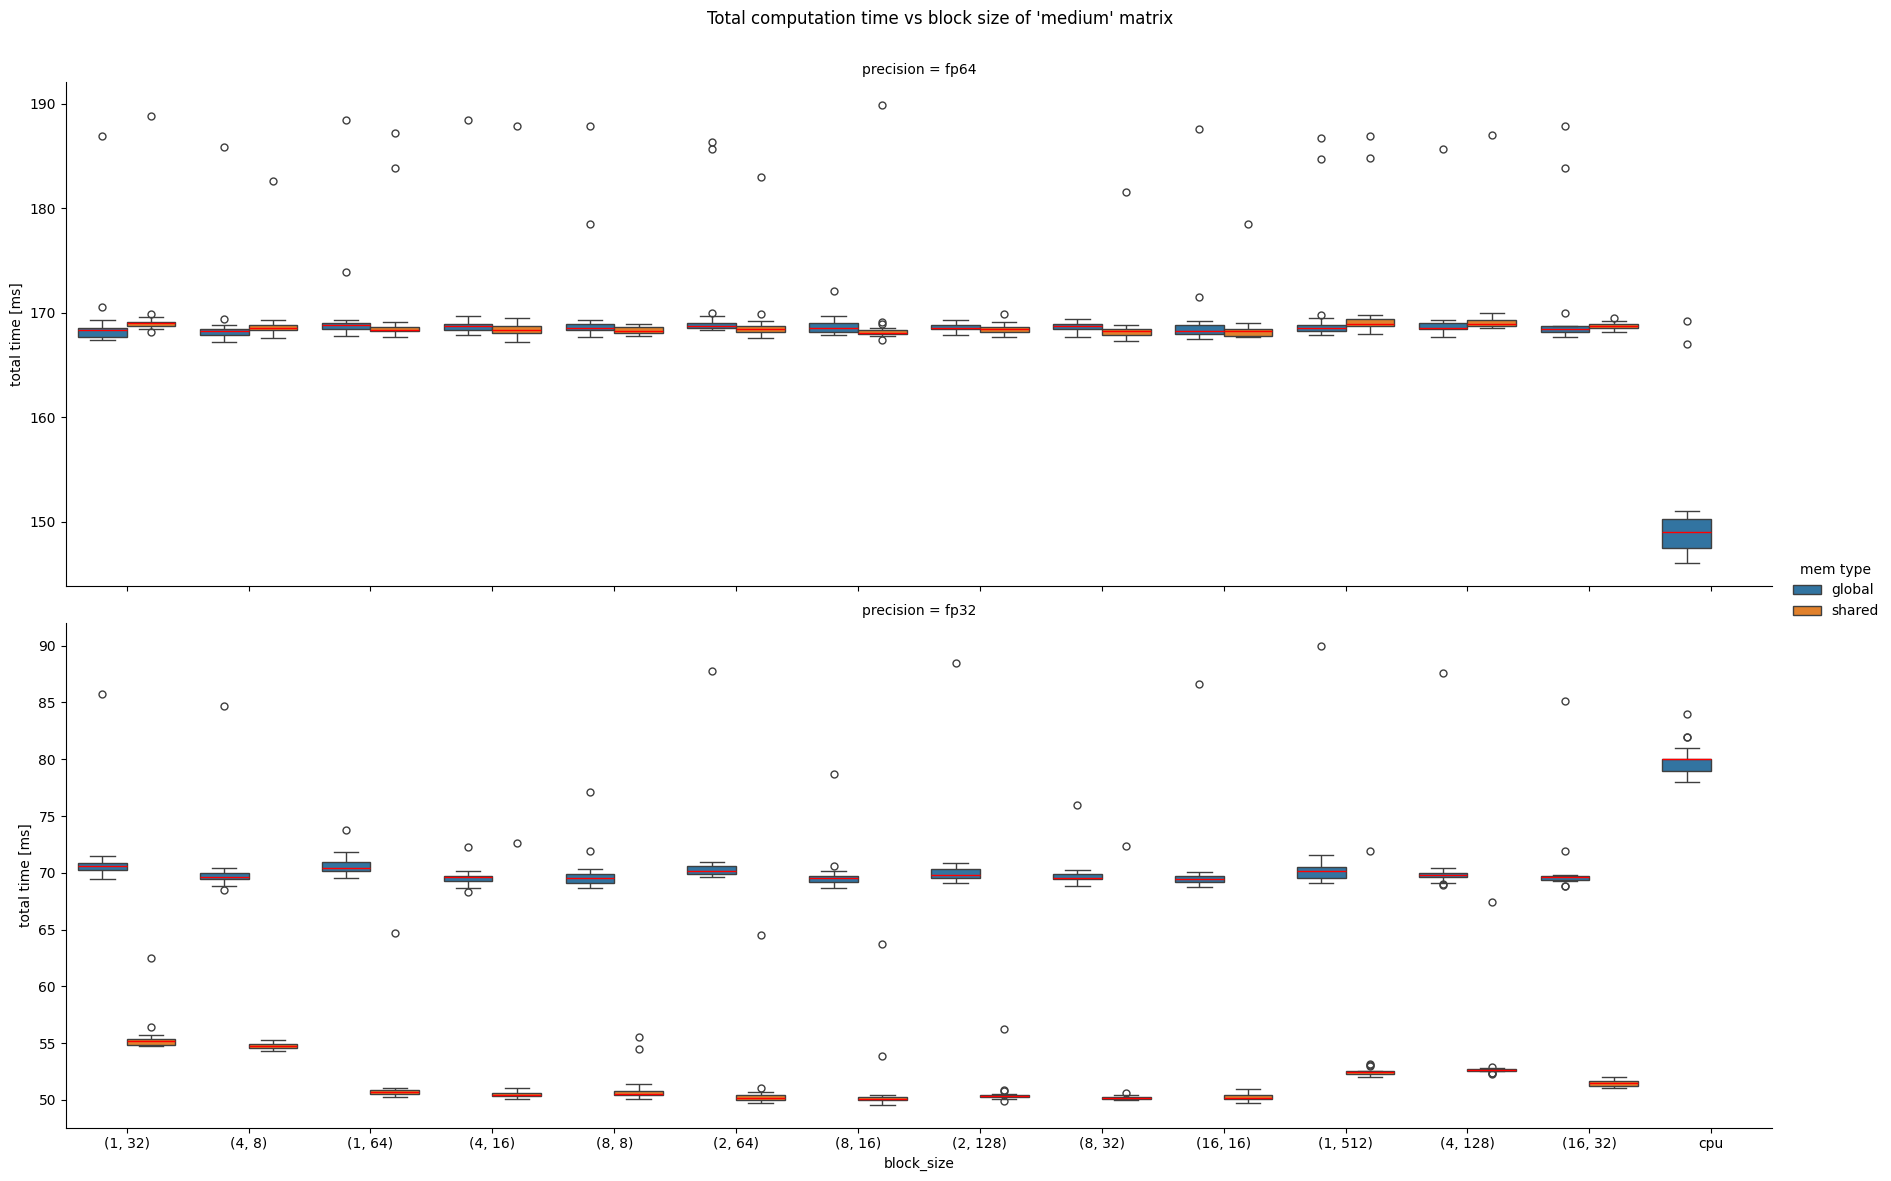

In [81]:
matrix_name = "medium"

df = results_novertical.query(f"input_name == '{matrix_name}'")

g = sns.catplot(
    data=df,
    row="precision",
    x="block_size",
    y="total time [ms]",
    sharey=False,
    kind="box",
    hue="mem type",
    height=6,
    aspect=3,
    medianprops={'color': 'red', 'linewidth': 1} 
)

plt.suptitle(f"Total computation time vs block size of '{matrix_name}' matrix")
plt.subplots_adjust(top=0.92)
plt.show()

Bei der mittelgrossen Matrix bleibt für FP64 weiterhin kein Unterschied zwischen Global- und Shared-Memory erkennbar. Im Gegensatz dazu wird der Performancezuwachs für FP32 durch den Einsatz von Shared Memory noch deutlicher. So konnte die Berechnungszeit von etwa 70 ms auf rund 50 ms reduziert werden.

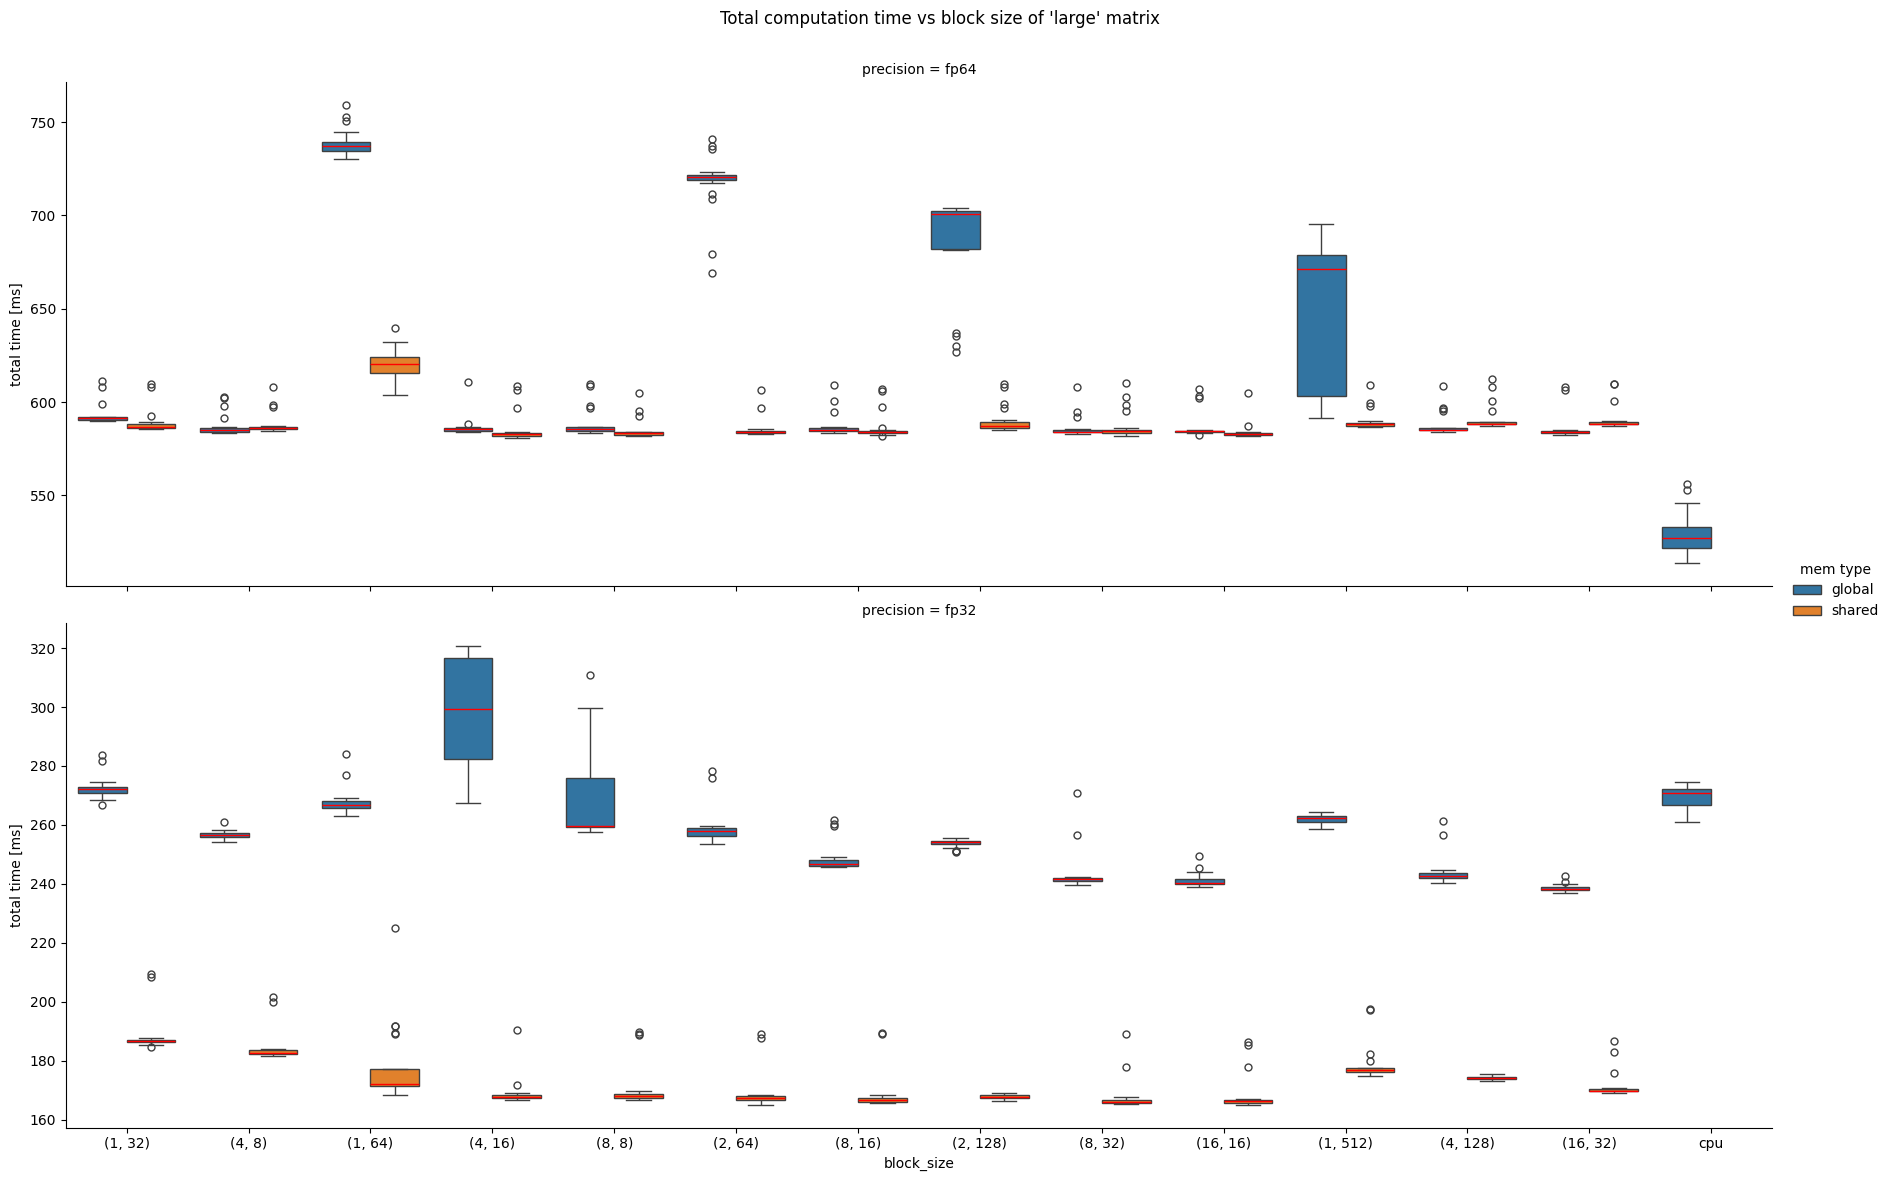

In [83]:
matrix_name = "large"

df = results_novertical.query(f"input_name == '{matrix_name}'")

g = sns.catplot(
    data=df,
    row="precision",
    x="block_size",
    y="total time [ms]",
    sharey=False,
    kind="box",
    hue="mem type",
    height=6,
    aspect=3,
    medianprops={'color': 'red', 'linewidth': 1} 
)

plt.suptitle(f"Total computation time vs block size of '{matrix_name}' matrix")
plt.subplots_adjust(top=0.92)
plt.show()

Bei FP64 sind nach wie vor keine nennenswerten Unterschiede zwischen der Nutzung von Global- und Shared Memory zu erkennen. Lediglich bei sehr langsamen Blockgrössen wie (1, 64), (2, 128) und (1, 512) konnte der Shared-Memory-Ansatz die Performance auf das Niveau der anderen Kernel bringen. Weshalb dies so geschieht, kann ich allerdings nicht genau sagen.

Für FP32 hingegen wird der Vorteil durch Shared Memory noch deutlicher. Hier liess sich die Berechnungszeit in bestimmten Fällen um etwa 60 bis 100 ms reduzieren.

Was sind deine Erkenntnisse bzgl. GPU-Memory-Allokation und des Daten-Transferes auf die GPU? Interpretiere deine Resultate.

Global Memory hat hohe Zugriffslatenzen, da es sich auf separaten Speicherchips befindet, obwohl es mit 24 GB sehr gross ist. Je näher der Speicher an den Kernen liegt, desto schneller sind die Zugriffe, da dieser auf demselben Chip liegt. Allerdings ist der direkt an den Kernen befindliche Speicher (Cache und Shared Memory) wesentlich kleiner als der Global Memory. Beispielsweise verfügt die RTX 4090 über 72 MB L2-Cache, der von allen Streaming Multiprocessors (SMs) geteilt wird, sowie 128 kB L1-Cache pro SM. 

Die Geschwindigkeit des Caches und Shared Memory resultiert aus seiner Nähe zu den Kernen, was schnelle Zugriffe ermöglicht. Doch aufgrund der begrenzten Grösse sollten diese schnellen Speicher hauptsächlich für Daten genutzt werden, die wiederholt gebraucht werden. Eine intelligente Organisation und Nutzung des Speichers ist daher entscheidend, um die Vorteile des schnellen Zugriffs in Cache und Shared Memory bestmöglich auszuschöpfen und die Gesamtperformance zu steigern.

Deshalb hatte ich mich dazu entschieden die Singulärwerte auf das shared memory abzulegen, da diese für jedes einzelne Elemente der rekonstruierten Matrix benötigt wird. Um auch grosse Matrizen berechnen zu können nutze ich Tiling.

##### 5.2.3 Bonus: Weitere Optimierungen
Optimiere deine Implementation von oben weiter. Damit du Erfolg hast, muss der Data-Reuse noch grösser sein.

In [36]:
### BEGIN SOLUTION

### END SOLUTION

#### 5.3 NVIDIA Profiler

Benutze einen Performance Profiler von NVIDIA, um Bottlenecks in deinem Code zu identifizieren bzw. unterschiedliche Implementierungen (Blocks, Memory etc.) zu vergleichen. 

* Siehe Beispiel example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) für das Profiling des Codes und die Inspektion der Ergebnisse (neuste Variante)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe, welche Bottlenecks du gefunden bzw. entschärft hast.

Viele Optimierungen habe ich bereits auf dem Weg hierher vorgenommen. Nachfolgend fasse ich die Bottlenecks zusammen, welche ich gefunden habe und wie ich diese evtl behoben habe.

##### FP64 vs FP32 and Memory Coalescing

Zuerst wolle ich nur mit FP64 arbeiten, da numpy standardmässig genau so mit FP64 rechnet. Allerdings musste ich schnell feststellen, dass die GPU nicht die gewünschten Resultate bringt und die CPU mit meiner Rekonstruktionsmethode (ohne Matrixmultiplikation) generell schneller war.

Ich profile nun die Kernel mit dem script `nsc_fp64_vs_fp32.py` via *Nsight Compute*.

Nsight Compute hat folgende Probleme für den Kernel ```src.kernels.global_mem.fp64``` entdeckt:

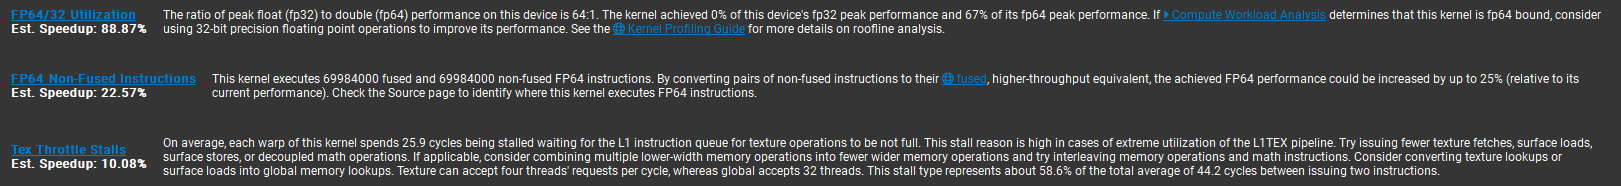

1. Der erste Punkt sei, dass keine FP32 Operationen genutzt werden und dass FP32 64 Mal schneller rechnen kann. Da zeigte sich der Grund, weshalb wahrscheinlich die CPU schneller war als die GPU. Da die Task darin bestelt Bilder zu rekonstruieren, wäre es wahrscheinlich okay wenn ich zu FP32 wechsle und den Speedup mitnehme und dabei auf die Präzision verzichte.
2. Der zweite Punkt seien Non-Fused instructions. Ich habe dies optimiert, indem ich einen zusätzlichen Kernel schrieb, welcher FMA nutzt.
3. Der dritte Punkt sei *Tex Throttle Stalls*. Dies weist darauf hin, dass Warps pausiert werden, durch z.B. Memoryzugriffe. Möglicherweise sind also die Zugriffe auf das global-memory nicht ideal. Möglicherweise kann dies durch eine andere Blockgrösse (sodass Memory-Coalescing besser funktioniert) oder Nutzung des Shared memory verbessert werden.

Um die Berechnung zu beschleunigen und der Punkt 1 von Oben zu beheben, nutze ich nun den ```fp32``` Kernel:

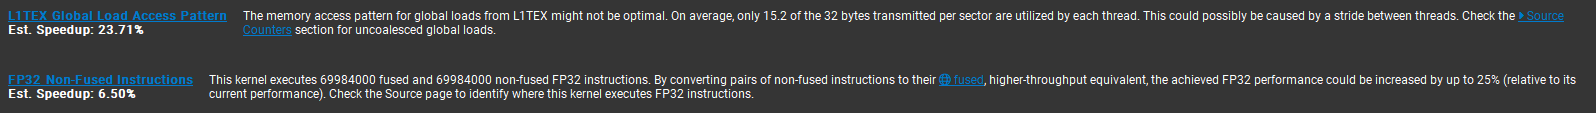

Bei diesem Kernel ist der *FP64/FP32 Utilization* Punkt nun verschwunden, allerdings seinen nun die global loads nicht optimal. Dies hängt wahrscheinlich damit zusammen, dass das Memory-Coalescing nicht effizient arbeiten kann. Wie der Profiler schon sagt, liegt es möglicherweise an strides zwischen den geladenen elementen. Die Blockgrösse *(8, 16)* ist möglicherweise daran schuld, dass nur 16 Elemente effizient geladen werden können. Wenn ich die Grösse auf (n, 32) ändere, könnte das Coalescing-Effizienter arbeiten.

Ausserdem reklamiert der Profiler auch hier wieder wegen Non-Fused instructions, allerdings ist der estimated speedup nicht so gross, weshalb ich dies so lasse.

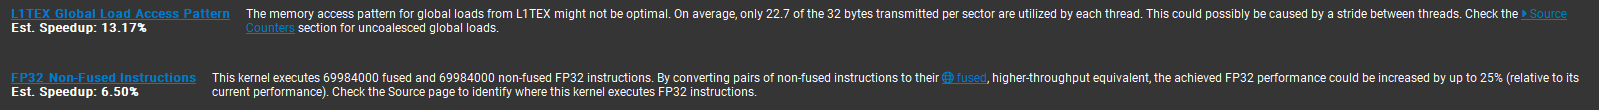

Nachdem ich eine neue Blockgrösse von (4, 32) verwende ist *L1TEX Global Load Access Pattern* besser geworden. Nun werden 22.7 bytes Verwendet. Somit ist das Memory-Coalescing nun effizienter, da jeder Warp nun auf eine Zeile passt.

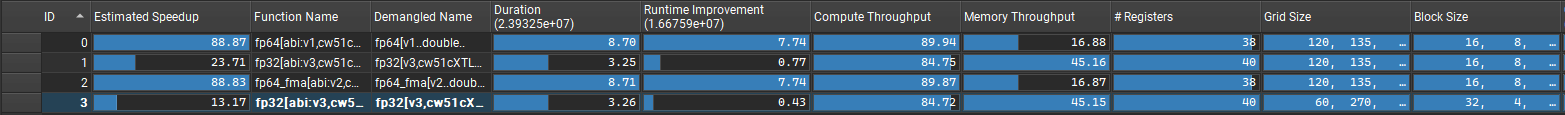

Legende: 
- ID0: FP64 (ohne shared memory) ohne FMA
- ID1: FP32 (ohne shared memory) ohne optimiertes Coalescing (Blockgrösse: (8, 16))
- ID2: FP64 (ohne shared memory) mit FMA
- ID3: FP32 (ohne shared memory) mit optimiertem Coalescing (Blockgrösse: (4, 32))

Schauen wir nochmals über die overview, so lässt sich zeigen (Duration Spalte), dass FP32 nur ca 1/3 der Zeit benötigt um die Berechnung auszuführen gegenüber FP64. FMA bei FP64 zeigt allerdings keinen speedup gegenüber der Non-FMA Version. Auch das optimiertere Memory-Coalescing bei FP32 zeigt keinen wirklichen Speedup gegenüber dem FP32 Kernel mit Blockgrösse (8, 16). Wahrscheinlich ist dies so weil nun die Blockgrösse nicht mehr ideal gegenüber der Matrixgrösse ist.

Betrachtet man die Spalte ganz links, so haben alle Verbesserungen den Estimated Speedup erfolgreich verkleinert.



<font color='blue'>Antwort hier eingeben inkl. Bild.</font>

### 6 Beschleunigte Rekonstruktion mehrerer Bilder
#### 6.1 Implementierung
Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Untersuche dies auch für grössere Inputs als die MRI-Bilder.

In [37]:
### BEGIN SOLUTION

### END SOLUTION

<font color='blue'>Antwort hier eingeben</font>

#### 6.2 Analyse
Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson.

<font color='blue'>Antwort hier eingeben</font>

#### 6.3 Komponentendiagramm

Erstelle das Komponentendiagramm dieser Mini-Challenge für die Rekunstruktion mehrere Bilder mit einer GPU-Implementierung. Erläutere das Komponentendigramm in 3-4 Sätzen.


<font color='blue'>Antwort hier eingeben inkl. Bild(ern).</font>

### 7 Reflexion

Reflektiere die folgenden Themen indem du in 3-5 Sätzen begründest und anhand von Beispielen erklärst.

1: Was sind deiner Meinung nach die 3 wichtigsten Prinzipien bei der Beschleunigung von Code?

<font color='blue'>Antwort hier eingeben</font>

2: Welche Rechenarchitekturen der Flynnschen Taxonomie wurden in dieser Mini-Challenge wie verwendet?

<font color='blue'>Antwort hier eingeben</font>

3: Haben wir es in dieser Mini-Challenge hauptsächlich mit CPU- oder IO-Bound Problemen zu tun? Nenne Beispiele.

<font color='blue'>Antwort hier eingeben</font>

4: Wie könnte diese Anwendung in einem Producer-Consumer Design konzipiert werden?

<font color='blue'>Antwort hier eingeben</font>

5: Was sind die wichtigsten Grundlagen, um mehr Performance auf der GPU in dieser Mini-Challenge zu erreichen?

<font color='blue'>Antwort hier eingeben</font>

6: Reflektiere die Mini-Challenge. Was ist gut gelaufen? Wo gab es Probleme? Wo hast du mehr Zeit als geplant gebraucht? Was hast du dabei gelernt? Was hat dich überrascht? Was hättest du zusätzlich lernen wollen? Würdest du gewisse Fragestellungen anders formulieren? Wenn ja, wie?

<font color='blue'>Antwort hier eingeben</font>